# Information Extraction

In [1]:
%load_ext autoreload
%autoreload 2

# Run this code cell to set notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95%; }</style>"))

## Import Libraries

In [2]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import os
import re
import cv2
import copy
import glob
import json
import torch
import string
import random
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from dateutil.parser import parse
from sklearn.manifold import TSNE
from difflib import SequenceMatcher
from torch_geometric.nn import GCNConv, ChebConv
from torch.optim.lr_scheduler import CyclicLR
from torch_geometric.data import Data as G_Data
from sklearn.metrics import classification_report
from pytorch_lightning.loggers import TensorBoardLogger
from torch_geometric.data import LightningDataset as G_LightningDataset
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from config import config as conf
random.seed(42)

## Data Pre-Processing, Visualization and Loader Definition

In [3]:
def get_raw_data_df(dirs, is_train=True, need_test_record_with_label=False, save_path=conf.DATA_DIR_PROCESSED, save_file_name='data.csv', columns=['file_path', 'image', 'txt', 'is_train', 'is_test']):
    data = []
    for dir_path in dirs:
        print(f"Fetching data from {dir_path}")
        files = glob.glob(dir_path + "/*.jpg")
        for file in files:
            file_name = file.split('/')[-1].split('.')[0]
            if os.path.exists(os.path.join(dir_path, file_name+'.txt')):
                data.append([
                    dir_path,
                    file_name+'.jpg',
                    file_name+'.txt',
                    int(is_train),
                    int(not is_train)
                ])
    df = pd.DataFrame(data, columns=columns)
    df['is_test_with_label'] = 0
    if is_train and need_test_record_with_label:
        for i in random.choices(np.arange(0, len(df)), k=2):
            df.at[i, 'is_test_with_label'] = 1
    df.to_csv(os.path.join(save_path, save_file_name))
    return df

df_ocr = pd.concat([get_raw_data_df(dirs=conf.DATA_TRAIN_OCR_ENGINE, need_test_record_with_label=True, save_file_name='raw_train_orc.csv'), get_raw_data_df(dirs=conf.DATA_TEST, is_train=False, save_file_name='raw_test_ocr.csv')]).reset_index(drop=True)
print(f"\nTrain data length = {df_ocr['is_train'].value_counts()[1]}\nTest data length = {df_ocr['is_train'].value_counts()[0]}")
df_ocr

Fetching data from ../../../data/raw/train-1
Fetching data from ../../../data/raw/test-1

Train data length = 704
Test data length = 360


file_path             image               txt  is_train  \
0     ../../../data/raw/train-1  X51005719917.jpg  X51005719917.txt         1   
1     ../../../data/raw/train-1  X51006556818.jpg  X51006556818.txt         1   
2     ../../../data/raw/train-1  X00016469612.jpg  X00016469612.txt         1   
3     ../../../data/raw/train-1  X00016469619.jpg  X00016469619.txt         1   
4     ../../../data/raw/train-1  X00016469620.jpg  X00016469620.txt         1   
...                         ...               ...               ...       ...   
1059   ../../../data/raw/test-1  X51009008091.jpg  X51009008091.txt         0   
1060   ../../../data/raw/test-1  X51009008095.jpg  X51009008095.txt         0   
1061   ../../../data/raw/test-1  X51009447842.jpg  X51009447842.txt         0   
1062   ../../../data/raw/test-1  X51009453729.jpg  X51009453729.txt         0   
1063   ../../../data/raw/test-1  X51009568881.jpg  X51009568881.txt         0   

      is_test  is_test_with_label  
0           0                   0  
1           0                   0  
2           0                   0  
3           0                   0  
4           0                   0  
...       ...                 ...  
1059        1                   0  
1060        1                   0  
1061        1                   0  
1062        1                   0  
1063        1                   0  

[1064 rows x 6 columns]

In [4]:
df_ie = get_raw_data_df(dirs=conf.DATA_TRAIN_IE, save_file_name='raw_train_ie.csv', columns=['ie_file_path', 'image', 'txt', 'is_train', 'is_test'])
print(f"\nTrain data length = {df_ie['is_train'].value_counts()}")
df_ie

Fetching data from ../../../data/raw/train-2

Train data length = 1    727
Name: is_train, dtype: int64


ie_file_path                image                  txt  \
0    ../../../data/raw/train-2     X00016469612.jpg     X00016469612.txt   
1    ../../../data/raw/train-2     X00016469619.jpg     X00016469619.txt   
2    ../../../data/raw/train-2     X00016469620.jpg     X00016469620.txt   
3    ../../../data/raw/train-2     X00016469622.jpg     X00016469622.txt   
4    ../../../data/raw/train-2     X00016469623.jpg     X00016469623.txt   
..                         ...                  ...                  ...   
722  ../../../data/raw/train-2     X51007339164.jpg     X51007339164.txt   
723  ../../../data/raw/train-2     X51007339165.jpg     X51007339165.txt   
724  ../../../data/raw/train-2  X51007339166(1).jpg  X51007339166(1).txt   
725  ../../../data/raw/train-2  X51007339166(2).jpg  X51007339166(2).txt   
726  ../../../data/raw/train-2     X51007339166.jpg     X51007339166.txt   

     is_train  is_test  is_test_with_label  
0           1        0                   0  
1           1        0                   0  
2           1        0                   0  
3           1        0                   0  
4           1        0                   0  
..        ...      ...                 ...  
722         1        0                   0  
723         1        0                   0  
724         1        0                   0  
725         1        0                   0  
726         1        0                   0  

[727 rows x 6 columns]

In [5]:
df_ocr_merged = df_ocr.merge(df_ie[['ie_file_path', 'image', 'txt']], how='left', on=['image', 'txt'])
df_ocr_merged = df_ocr_merged[['file_path', 'ie_file_path', 'image', 'txt', 'is_train', 'is_test', 'is_test_with_label']]
df_ocr_merged

file_path               ie_file_path             image  \
0     ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
1     ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
2     ../../../data/raw/train-1  ../../../data/raw/train-2  X00016469612.jpg   
3     ../../../data/raw/train-1  ../../../data/raw/train-2  X00016469619.jpg   
4     ../../../data/raw/train-1  ../../../data/raw/train-2  X00016469620.jpg   
...                         ...                        ...               ...   
1059   ../../../data/raw/test-1                        NaN  X51009008091.jpg   
1060   ../../../data/raw/test-1                        NaN  X51009008095.jpg   
1061   ../../../data/raw/test-1                        NaN  X51009447842.jpg   
1062   ../../../data/raw/test-1                        NaN  X51009453729.jpg   
1063   ../../../data/raw/test-1                        NaN  X51009568881.jpg   

                   txt  is_train  is_test  is_test_with_label  
0     X51005719917.txt         1        0                   0  
1     X51006556818.txt         1        0                   0  
2     X00016469612.txt         1        0                   0  
3     X00016469619.txt         1        0                   0  
4     X00016469620.txt         1        0                   0  
...                ...       ...      ...                 ...  
1059  X51009008091.txt         0        1                   0  
1060  X51009008095.txt         0        1                   0  
1061  X51009447842.txt         0        1                   0  
1062  X51009453729.txt         0        1                   0  
1063  X51009568881.txt         0        1                   0  

[1064 rows x 7 columns]

In [6]:
df_ocr_merged[df_ocr_merged['is_test_with_label'] == 1]

file_path               ie_file_path             image  \
17   ../../../data/raw/train-1  ../../../data/raw/train-2  X51006713996.jpg   
450  ../../../data/raw/train-1  ../../../data/raw/train-2  X51005447848.jpg   

                  txt  is_train  is_test  is_test_with_label  
17   X51006713996.txt         1        0                   1  
450  X51005447848.txt         1        0                   1

In [7]:
def strip_string(s):
    return s.strip()

def resize_point(image_width, image_height, point, size=(conf.RESIZE_WIDTH, conf.RESIZE_HEIGHT)):
    new_w, new_h = size
    ratio_w = new_w / image_width
    ratio_h = new_h / image_height
    return (point[0] * ratio_w, point[1] * ratio_h)

In [8]:
def get_normalized_entities(record):
    image = cv2.imread(os.path.join(record['file_path'], record['image']))
    h, w = image.shape[:2]
    x_coords, y_coords = [], []
    with open(os.path.join(record['file_path'], record['txt']), errors='ignore') as f:
        lines = f.readlines()
    for line in lines:
        line_content = list(map(strip_string, line.split(',')))
        for i in line_content[:8][0::2]:
            x_coords.append(int(i))
        for i in line_content[:8][1::2]:
            y_coords.append(int(i))
    record['doc_xmin'] = min(x_coords)
    record['doc_xmax'] = max(x_coords)
    record['doc_ymin'] = min(y_coords)
    record['doc_ymax'] = max(y_coords)
    record['width'] = w
    record['height'] = h
    record['normalized_width'] = max(x_coords) - min(x_coords)
    record['normalized_height'] = max(y_coords) - min(y_coords)
    return record

if os.path.exists(conf.DATA_DIR_PROCESSED + '/interim-normalized-data.csv'):
    df_ocr_merged = pd.read_csv(conf.DATA_DIR_PROCESSED + '/interim-normalized-data.csv')
else:
    df_ocr_merged = df_ocr_merged.apply(get_normalized_entities, axis=1) 
    df_ocr_merged.to_csv(conf.DATA_DIR_PROCESSED + '/interim-normalized-data.csv', index=False)

df_ocr_merged

Corrupt JPEG data: bad Huffman code


file_path               ie_file_path             image  \
0     ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
1     ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
2     ../../../data/raw/train-1  ../../../data/raw/train-2  X00016469612.jpg   
3     ../../../data/raw/train-1  ../../../data/raw/train-2  X00016469619.jpg   
4     ../../../data/raw/train-1  ../../../data/raw/train-2  X00016469620.jpg   
...                         ...                        ...               ...   
1059   ../../../data/raw/test-1                        NaN  X51009008091.jpg   
1060   ../../../data/raw/test-1                        NaN  X51009008095.jpg   
1061   ../../../data/raw/test-1                        NaN  X51009447842.jpg   
1062   ../../../data/raw/test-1                        NaN  X51009453729.jpg   
1063   ../../../data/raw/test-1                        NaN  X51009568881.jpg   

                   txt  is_train  is_test  is_test_with_label  doc_xmin  \
0     X51005719917.txt         1        0                   0       101   
1     X51006556818.txt         1        0                   0        18   
2     X00016469612.txt         1        0                   0        27   
3     X00016469619.txt         1        0                   0        16   
4     X00016469620.txt         1        0                   0        14   
...                ...       ...      ...                 ...       ...   
1059  X51009008091.txt         0        1                   0        35   
1060  X51009008095.txt         0        1                   0        65   
1061  X51009447842.txt         0        1                   0        86   
1062  X51009453729.txt         0        1                   0        10   
1063  X51009568881.txt         0        1                   0        45   

      doc_xmax  doc_ymin  doc_ymax  width  height  normalized_width  \
0          868       137      2609    932    2679               767   
1          587        67      1158    616    1200               569   
2          443        25       977    463    1013               416   
3          400        50       958    439    1004               384   
4          436        47       899    459     949               422   
...        ...       ...       ...    ...     ...               ...   
1059       699        93      1645    746    1824               664   
1060       674       150      1241    744    1286               609   
1061       864       184      1675    928    1769               778   
1062       524        21       913    615     931               514   
1063       814       276      1623    884    1678               769   

      normalized_height  
0                  2472  
1                  1091  
2                   952  
3                   908  
4                   852  
...                 ...  
1059               1552  
1060               1091  
1061               1491  
1062                892  
1063               1347  

[1064 rows x 15 columns]

In [9]:
def get_label(text_set, label_dict):
    for k, v in label_dict.items():
        cleaned_value_set = v.replace(',', '').strip().split()
        matches = 0
        for i in text_set:
            if any(SequenceMatcher(a=re.sub(r'[^\w]', '', i), b=re.sub(r'[^\w]', '', j)).ratio() > 0.8 for j in cleaned_value_set if len(i) > 1):
                matches += 1
            if (matches / len(text_set)) >= 0.75 or matches == len(cleaned_value_set):
                return k.upper().strip()
    return "OTHERS"
    
def prepare_df(df, resize=(conf.RESIZE_WIDTH, conf.RESIZE_HEIGHT), save_path=conf.DATA_DIR_PROCESSED, save_file_name='processed-data.csv'):
    data = []
    for ind, row in tqdm(df.iterrows()):
        base_data = [
            row['file_path'],
            row['ie_file_path'],
            row['image'],
            row['txt'],
            row['width'],
            row['height'],
            row['normalized_width'],
            row['normalized_height'],
            row['doc_xmin'],
            row['doc_xmax'],
            row['doc_ymin'],
            row['doc_ymax'],
            row['is_train'],
            row['is_test'],
            row['is_test_with_label']
        ]
        with open(os.path.join(row['file_path'], row['txt']), errors='ignore') as f:
            lines = f.readlines()
        if type(row['ie_file_path']) is str:
            with open(os.path.join(row['ie_file_path'], row['txt']), errors='ignore') as f:
                label_lines = f.readlines()
            label_lines = [i.strip() for i in label_lines]
            ie_string = ''.join(label_lines)
            ie_data = json.loads(ie_string)
        else:
            ie_data = None
        for line in lines:
            label = None
            normalized_annotation = []
            line_content = list(map(strip_string, line.split(',')))
            coord_content = list(map(int, line_content[:8]))
            for ind, coord in enumerate(coord_content):
                if ind % 2 == 0:
                    coord -= row['doc_xmin']
                else:
                    coord -= row['doc_ymin']
                normalized_annotation.append(coord)
            text = ', '.join(line_content[8:])
            text_set = text.replace(",", "").strip().split()
            if ie_data:
                label = get_label(text_set, ie_data)
            else:
                label = np.NaN
            r_x1, r_y1 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[0], normalized_annotation[1]), resize)
            r_x2, r_y2 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[2], normalized_annotation[3]), resize)
            r_x3, r_y3 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[4], normalized_annotation[5]), resize)
            r_x4, r_y4 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[6], normalized_annotation[7]), resize)
            resized_annotations = [r_x1, r_y1, r_x2, r_y2, r_x3, r_y3, r_x4, r_y4]
            normalized_resized_annotations = [r_x1/resize[0], r_y1/resize[1], r_x2/resize[0], r_y2/resize[1], r_x3/resize[0], r_y3/resize[1], r_x4/resize[0], r_y4/resize[1]]
            derived_data = coord_content + normalized_annotation + resized_annotations + normalized_resized_annotations + [resize[0], resize[1]] + [text] + [label]
            data.append(
                base_data + derived_data
            )
    res = pd.DataFrame(data, columns=
        ['file_path', 'ie_file_path', 'image', 'txt', 'width', 'height', 'normalized_width', 'normalized_height', 'doc_xmin', 'doc_xmax', 'doc_ymin', 'doc_ymax', 'is_train', 'is_test', 'is_test_with_label']
      + ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'n_x1', 'n_y1', 'n_x2', 'n_y2', 'n_x3', 'n_y3', 'n_x4', 'n_y4', 'r_x1', 'r_y1', 'r_x2', 'r_y2', 'r_x3', 'r_y3', 'r_x4', 'r_y4', 'n_r_x1', 'n_r_y1', 'n_r_x2', 'n_r_y2', 'n_r_x3', 'n_r_y3', 'n_r_x4', 'n_r_y4', 'resize_width', 'resize_height', 'text', 'label_names']  
    )
    res['label'] = res['label_names'].apply(lambda x: conf.LABEL[x] if type(x) is str else np.NAN)
    res.to_csv(os.path.join(save_path, save_file_name), index=False)
    return res

if os.path.exists(conf.DATA_DIR_PROCESSED + '/processed-data.csv'):
    df_ocr_processed = pd.read_csv(conf.DATA_DIR_PROCESSED + '/processed-data.csv')
else:
    df_ocr_processed = prepare_df(df_ocr_merged)

df_ocr_processed

1064it [00:16, 63.13it/s] 


file_path               ie_file_path             image  \
0      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
1      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
2      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
3      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
4      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
...                          ...                        ...               ...   
56891   ../../../data/raw/test-1                        NaN  X51009568881.jpg   
56892   ../../../data/raw/test-1                        NaN  X51009568881.jpg   
56893   ../../../data/raw/test-1                        NaN  X51009568881.jpg   
56894   ../../../data/raw/test-1                        NaN  X51009568881.jpg   
56895   ../../../data/raw/test-1                        NaN  X51009568881.jpg   

                    txt  width  height  normalized_width  normalized_height  \
0      X51005719917.txt    932    2679               767               2472   
1      X51005719917.txt    932    2679               767               2472   
2      X51005719917.txt    932    2679               767               2472   
3      X51005719917.txt    932    2679               767               2472   
4      X51005719917.txt    932    2679               767               2472   
...                 ...    ...     ...               ...                ...   
56891  X51009568881.txt    884    1678               769               1347   
56892  X51009568881.txt    884    1678               769               1347   
56893  X51009568881.txt    884    1678               769               1347   
56894  X51009568881.txt    884    1678               769               1347   
56895  X51009568881.txt    884    1678               769               1347   

       doc_xmin  doc_xmax  ...    n_r_y2    n_r_x3    n_r_y3    n_r_x4  \
0           101       868  ...  0.000000  0.621904  0.010922  0.349413   
1           101       868  ...  0.016990  0.658409  0.028722  0.320730   
2           101       868  ...  0.040049  0.816167  0.052994  0.168188   
3           101       868  ...  0.060680  0.786180  0.071602  0.183833   
4           101       868  ...  0.079693  0.857888  0.093851  0.121252   
...         ...       ...  ...       ...       ...       ...       ...   
56891        45       814  ...  0.874536  0.475943  0.896808  0.386216   
56892        45       814  ...  0.873794  0.706112  0.899035  0.615085   
56893        45       814  ...  0.874536  0.966190  0.898293  0.859558   
56894        45       814  ...  0.933927  0.958388  0.971789  0.006502   
56895        45       814  ...  0.974759  0.945384  1.000000  0.019506   

         n_r_y4  resize_width  resize_height  \
0      0.010922           720           1080   
1      0.028722           720           1080   
2      0.052994           720           1080   
3      0.071602           720           1080   
4      0.093851           720           1080   
...         ...           ...            ...   
56891  0.896808           720           1080   
56892  0.899035           720           1080   
56893  0.898293           720           1080   
56894  0.971789           720           1080   
56895  1.000000           720           1080   

                                                    text  label_names  label  
0                                            TAX INVOICE       OTHERS    0.0  
1                                         DOMINO'S PIZZA       OTHERS    0.0  
2                              GST REF NO : 001694261248       OTHERS    0.0  
3                                DOMINO'S PIZZA SEGAMBUT       OTHERS    0.0  
4                            D-08, M AVENUE, JLN 1 / 38A       OTHERS    0.0  
...                                                  ...          ...    ...  
56891                                               9.81          NaN    NaN  
568

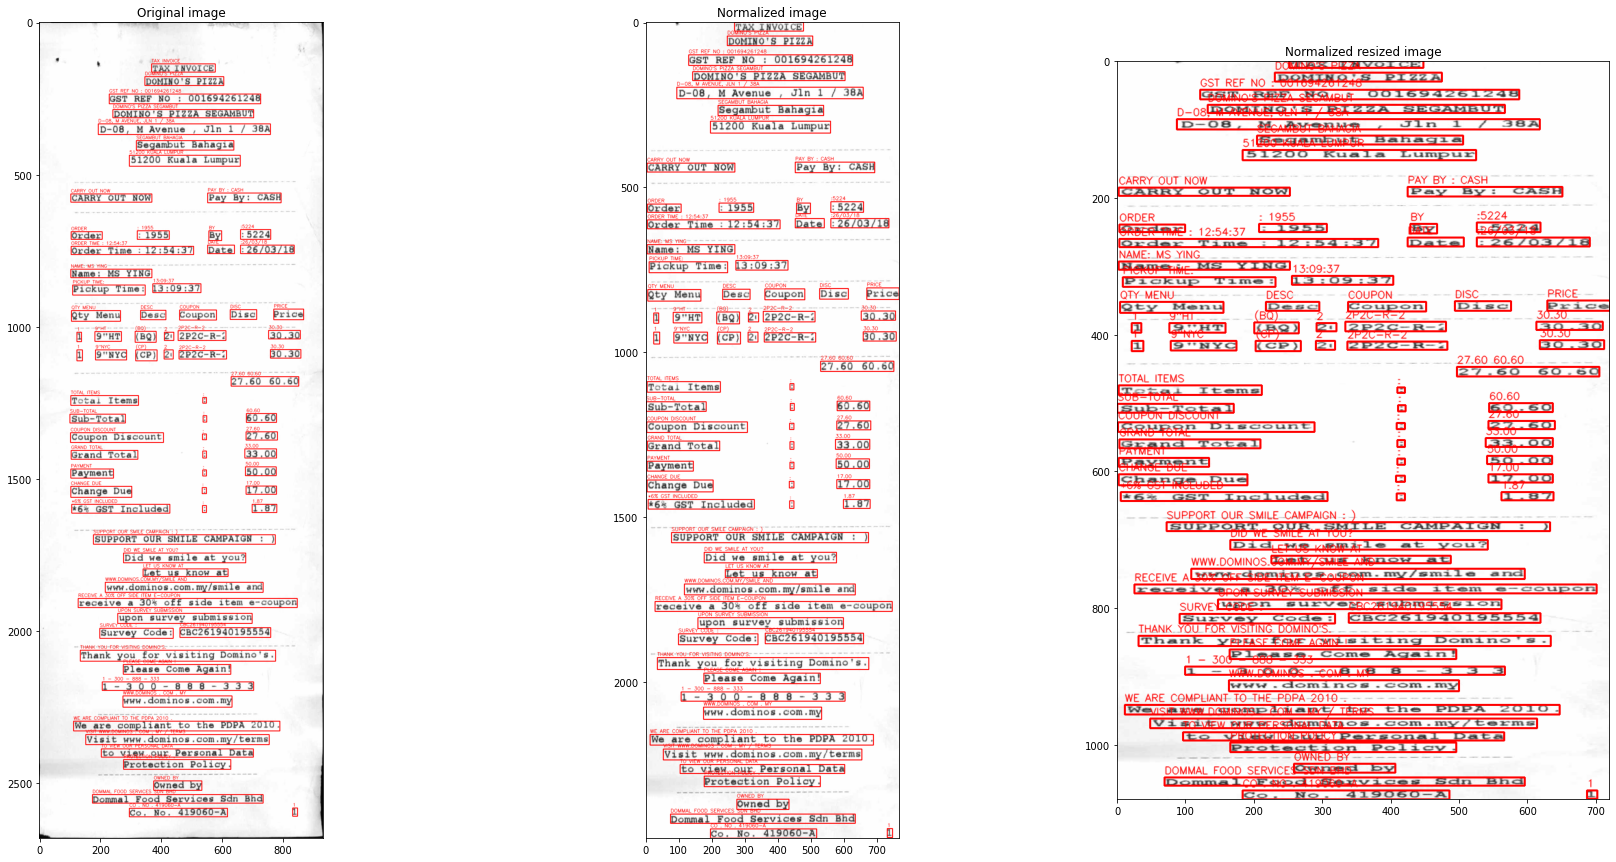

In [10]:
def plot_normalized_record(df, resize=(conf.RESIZE_WIDTH, conf.RESIZE_HEIGHT)):
    assert len(df['doc_xmin'].unique().tolist()) == 1 and len(df['doc_ymin'].unique().tolist()) == 1 and len(df['doc_xmax'].unique().tolist()) == 1 and len(df['doc_ymax'].unique().tolist()) == 1, 'df must have only one xmin, ymin, xmax and ymax values per document.'
    xmin, ymin, xmax, ymax = df['doc_xmin'].unique().tolist()[0], df['doc_ymin'].unique().tolist()[0], df['doc_xmax'].unique().tolist()[0], df['doc_ymax'].unique().tolist()[0]
    image = cv2.imread(os.path.join(df.iloc[0]['file_path'], df.iloc[0]['image']))
    image_copy = copy.deepcopy(image[ymin: ymax, xmin: xmax, :])
    image_resize = cv2.resize(image_copy, resize)
    for ind, row in df.iterrows():
        image = cv2.rectangle(image, (int(row['x1']), int(row['y1'])), (int(row['x3']), int(row['y3'])), (255, 0, 0), 2)
        image = cv2.putText(image, row['text'], (int(row['x1']), int(row['y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        image_copy = cv2.rectangle(image_copy, (int(row['n_x1']), int(row['n_y1'])), (int(row['n_x3']), int(row['n_y3'])), (255, 0, 0), 2)
        image_copy = cv2.putText(image_copy, row['text'], (int(row['n_x1']), int(row['n_y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        image_resize = cv2.rectangle(image_resize, (int(row['r_x1']), int(row['r_y1'])), (int(row['r_x3']), int(row['r_y3'])), (255, 0, 0), 2)
        image_resize = cv2.putText(image_resize, row['text'], (int(row['r_x1']), int(row['r_y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,15))
    ax1.imshow(image)
    ax1.set_title("Original image")
    ax2.imshow(image_copy)
    ax2.set_title("Normalized image")
    ax3.imshow(image_resize)
    ax3.set_title("Normalized resized image")

plot_normalized_record(df_ocr_processed[df_ocr_processed['image']=='X51005719917.jpg'])

0.0    29786
4.0     1811
1.0     1630
3.0      785
2.0      744
Name: label, dtype: int64


<AxesSubplot:title={'center':'Label count across docs -> n = 650'}>

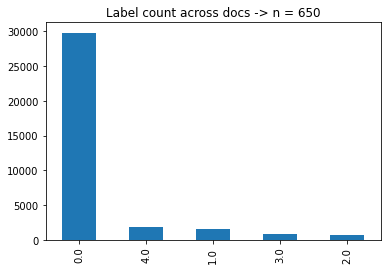

In [11]:
df_dataset = copy.deepcopy(df_ocr_processed[(~df_ocr_processed['label'].isnull()) & (df_ocr_processed['is_test_with_label'] != 1)])
print(df_dataset['label'].value_counts())
df_dataset['label'].value_counts().plot(kind='bar', title=f"Label count across docs -> n = {df_dataset['image'].nunique()}")

In [12]:
# Refer - https://github.com/dhavalpotdar/Graph-Convolution-on-Structured-Documents/blob/7400704346cb9698f6c6b1ad3307d2439d17fa33/grapher.py#L11
class Graph:
    
    def __init__(self, df, max_nodes=100, columns=['r_x1', 'r_y1', 'r_x3', 'r_y3', 'text'], label='label'):
        self.df = df
        self.df.reset_index(inplace=True)
        self.max_nodes = max_nodes
        self.xmin, self.ymin, self.xmax, self.ymax, self.text = columns
        self.label = label
        self.special_chars = {i: ind for ind, i in enumerate(string.punctuation)}
    
    def get_features(self):
        
        def is_aplha(s):
            return int(s.isalpha())

        def is_numeric(s):
            return int(s.isnumeric())

        def is_alnum(s):
            return int(s.isalnum())

        def is_decimal_number(s):
            return int(bool(re.match("[\d.\d]+$", s)))

        def is_number_with_symbols(s):
            return int(bool(re.match("[\d{}]+$".format(re.escape(string.punctuation)), s)))

        def is_date(s, fuzzy=False):
            try: 
                parse(s, fuzzy=fuzzy)
                return 1
            except (ValueError, OverflowError):
                return 0
        
        feats = []
        for ind, row in self.df.iterrows():
            is_char_upper, is_char_lower, is_char_alpha, is_char_digit, is_char_space = 0, 0, 0, 0, 0
            is_char_special = [0] * len(self.special_chars)
            is_word_alpha, is_word_numeric, is_word_alnum, is_word_decimal_number, is_word_number_with_symbol, is_word_date = 0, 0, 0, 0, 0, 0
            for c in row['text']:
                if c.islower(): is_char_lower += 1
                if c.isupper(): is_char_upper += 1
                if c.isalpha(): is_char_alpha += 1
                if c.isnumeric(): is_char_digit += 1
                if c.isspace(): is_char_space += 1
                if c in self.special_chars.keys():
                    is_char_special[self.special_chars[c]] += 1
            for word in row['text'].split():
                is_word_alpha += is_aplha(word)
                is_word_numeric += is_numeric(word)
                is_word_alnum += is_alnum(word)
                is_word_decimal_number += is_decimal_number(word)
                is_word_number_with_symbol += is_number_with_symbols(word)
                is_word_date += is_date(word)
            feat = [is_char_upper, is_char_lower, is_char_alpha, is_char_digit, is_char_space] + \
                   is_char_special + \
                   [is_word_alpha, is_word_numeric, is_word_alnum, is_word_decimal_number, is_word_number_with_symbol, is_word_date] + \
                   [row['n_r_x1'], row['n_r_y1'], row['n_r_x2'], row['n_r_y2'], row['n_r_x3'], row['n_r_x3'], row['n_r_x4'], row['n_r_y4']]
            feats.append(feat)
        return np.asarray(feats)
    
    def pad_adj(self, adj_matrix):
        n = adj_matrix.shape[0]
        target = np.zeros((self.max_nodes, self.max_nodes))
        if n < self.max_nodes:
            target[:n, :n] = adj_matrix
        elif n > self.max_nodes:
            target = adj_matrix[:self.max_nodes, :self.max_nodes]
        else:
            target = adj_matrix
        return target
    
    def pad_feats(self, feats):
        target = np.zeros((self.max_nodes, feats.shape[1]))
        if feats.shape[0] < self.max_nodes:
            target[:feats.shape[0], :feats.shape[1]] = feats
        elif feats.shape[0] > self.max_nodes:
            target = feats[:self.max_nodes, :feats.shape[1]]
        else:
            target = feats
        return feats
    
    def get_edge_index(self):
        edge_index = []
        node_index = self.df.index.to_list()
        for ind, row in self.df.iterrows():
            if row['vertically_close_object_ids'] in node_index:
                edge_index.append([node_index.index(ind), node_index.index(row['vertically_close_object_ids'])])
                edge_index.append([node_index.index(row['vertically_close_object_ids']), node_index.index(ind)])
            if row['horizontally_close_object_ids'] in  node_index:
                edge_index.append([node_index.index(ind), node_index.index(row['horizontally_close_object_ids'])])
                edge_index.append([node_index.index(row['horizontally_close_object_ids']), node_index.index(ind)])
        return np.asarray(edge_index).T
    
    def get_goemetric_data(self, index, features):
        return G_Data(x=torch.from_numpy(features).float().contiguous(), edge_index=torch.from_numpy(index).type(torch.LongTensor).contiguous(), y=torch.Tensor(self.df[self.label].to_list()).type(torch.LongTensor).contiguous())
        
    def make_graph(self):
        graph = nx.from_dict_of_lists(self.graph_dict)
        adj_matrix_sparse = nx.adjacency_matrix(graph)
        adj_matrix = np.asarray(adj_matrix_sparse.todense())
        padded_adj_matrix = self.pad_adj(adj_matrix)
        feats = self.get_features()
        padded_feats = self.pad_feats(feats)
        edge_index = self.get_edge_index()
        data = self.get_goemetric_data(edge_index, feats)
        return graph, padded_adj_matrix, padded_feats, adj_matrix, edge_index, feats, data
         
    def generate(self):
        distances_vertical, distances_horizontal = [], []
        nearest_dst_ids_vertical, nearest_dst_ids_horizontal = [], []
        x_src_coord_vertical, y_src_coord_vertical, x_dst_coord_vertical, y_dst_coord_vertical = [], [], [], []
        x_src_coord_horizontal, y_src_coord_horizontal, x_dst_coord_horizontal, y_dst_coord_horizontal = [], [], [], []
        for src_ind, src_row in self.df.iterrows():
            dst_attributes_vertical, dst_attributes_horizontal = [], []
            is_beneath = False
            src_x_range = (src_row[self.xmin], src_row[self.xmax])
            src_y_range = (src_row[self.ymin], src_row[self.ymax])
            src_centroid_x = (src_x_range[0] + src_x_range[1]) / 2
            src_centroid_y = (src_y_range[0] + src_y_range[1]) / 2
            for dst_ind, dst_row in self.df.iterrows():
                dst_x_range = (dst_row[self.xmin], dst_row[self.xmax])
                dst_y_range = (dst_row[self.ymin], dst_row[self.ymax])
                dst_centroid_x = (dst_x_range[0] + dst_x_range[1]) / 2
                dst_centroid_y = (dst_y_range[0] + dst_y_range[1]) / 2
                if src_ind != dst_ind:
                    if dst_centroid_y > src_centroid_y:
                        if dst_x_range[0] <= src_x_range[0] and dst_x_range[1] >= src_x_range[1]:
                            x_common = (src_x_range[0] + src_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                            is_beneath = True
                        elif dst_x_range[0] >= src_x_range[0] and dst_x_range[1] <= src_x_range[1]:
                            x_common = (dst_x_range[0] + dst_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                            is_beneath = True
                        elif dst_x_range[0] <= src_x_range[0] and dst_x_range[1] >= src_x_range[0] and dst_x_range[1] <= src_x_range[1]:
                            x_common = (src_x_range[0] + dst_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                            is_beneath = True
                        elif dst_x_range[0] >= src_x_range[0] and dst_x_range[0] <= src_x_range[1] and dst_x_range[1] >= src_x_range[1]:
                            x_common = (dst_x_range[0] + src_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                            is_beneath = True
                if dst_centroid_x > src_centroid_x:
                    if dst_y_range[0] <= src_y_range[0] and dst_y_range[1] >= src_y_range[1]:
                        y_common = (src_y_range[0] + src_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] >= src_y_range[0] and dst_y_range[1] <= src_y_range[1]:
                        y_common = (dst_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] <= src_y_range[0] and dst_y_range[1] >= src_y_range[1] and dst_y_range[1] <= src_y_range[1]:
                        y_common = (src_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] >= src_y_range[0] and dst_y_range[0] <= src_y_range[1] and dst_y_range[1] >= src_y_range[1]:
                        y_common = (src_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
            dst_attributes_vertical_sorted, dst_attributes_horizontal_sorted = sorted(dst_attributes_vertical, key=lambda x: x[3]), sorted(dst_attributes_horizontal, key=lambda x: x[3])
            if len(dst_attributes_vertical_sorted) == 0:
                nearest_dst_ids_vertical.append(-1)
                x_src_coord_vertical.append(-1)
                y_src_coord_vertical.append(-1)
                x_dst_coord_vertical.append(-1)
                y_dst_coord_vertical.append(-1)
                distances_vertical.append(-1)
            else:
                nearest_dst_ids_vertical.append(dst_attributes_vertical_sorted[0][0])
                x_src_coord_vertical.append(dst_attributes_vertical_sorted[0][1][0])
                y_src_coord_vertical.append(dst_attributes_vertical_sorted[0][1][1])
                x_dst_coord_vertical.append(dst_attributes_vertical_sorted[0][2][0])
                y_dst_coord_vertical.append(dst_attributes_vertical_sorted[0][2][1])
                distances_vertical.append(dst_attributes_vertical_sorted[0][3])
            if len(dst_attributes_horizontal_sorted) == 0:
                nearest_dst_ids_horizontal.append(-1)
                x_src_coord_horizontal.append(-1)
                y_src_coord_horizontal.append(-1)
                x_dst_coord_horizontal.append(-1)
                y_dst_coord_horizontal.append(-1)
                distances_horizontal.append(-1)
            else:
                nearest_dst_ids_horizontal.append(dst_attributes_horizontal_sorted[0][0])
                x_src_coord_horizontal.append(dst_attributes_horizontal_sorted[0][1][0])
                y_src_coord_horizontal.append(dst_attributes_horizontal_sorted[0][1][1])
                x_dst_coord_horizontal.append(dst_attributes_horizontal_sorted[0][2][0])
                y_dst_coord_horizontal.append(dst_attributes_horizontal_sorted[0][2][1])
                distances_horizontal.append(dst_attributes_horizontal_sorted[0][3])
        vertically_close_objects, horizontally_close_objects = [], []
        for i in nearest_dst_ids_vertical:
            if i == -1:
                vertically_close_objects.append('')
            else:
                vertically_close_objects.append(self.df.loc[i, 'text'])
        for i in nearest_dst_ids_horizontal:
            if i == -1:
                horizontally_close_objects.append('')
            else:
                horizontally_close_objects.append(self.df.loc[i, 'text'])
        self.df['vertically_close_objects'] = vertically_close_objects
        self.df['vertically_close_object_ids'] = nearest_dst_ids_vertical
        self.df['vertically_close_object_x_src_coord_centroid'] = x_src_coord_vertical
        self.df['vertically_close_object_y_src_coord_centroid'] = y_src_coord_vertical
        self.df['vertically_close_object_x_dst_coord_centroid'] = x_dst_coord_vertical
        self.df['vertically_close_object_y_dst_coord_centroid'] = y_dst_coord_vertical
        self.df['vertically_close_object_distances'] = distances_vertical
        self.df['horizontally_close_objects'] = horizontally_close_objects
        self.df['horizontally_close_object_ids'] = nearest_dst_ids_horizontal
        self.df['horizontally_close_object_x_src_coord_centroid'] = x_src_coord_horizontal
        self.df['horizontally_close_object_y_src_coord_centroid'] = y_src_coord_horizontal
        self.df['horizontally_close_object_x_dst_coord_centroid'] = x_dst_coord_horizontal
        self.df['horizontally_close_object_y_dst_coord_centroid'] = y_dst_coord_horizontal
        self.df['horizontally_close_object_distances'] = distances_horizontal
        grouped_vertical = self.df.groupby('vertically_close_object_ids')['vertically_close_object_distances'].min()
        grouped_horizontal = self.df.groupby('horizontally_close_object_ids')['horizontally_close_object_distances'].min()
        grouped_vertical_dict = dict(zip(grouped_vertical.index, grouped_vertical.values))
        grouped_horizontal_dict = dict(zip(grouped_horizontal.index, grouped_horizontal.values))
        revised_distances_vertical, revised_distances_hotizontal = [], []
        revised_x_src_coord_vertical, revised_y_src_coord_vertical, revised_x_dst_coord_vertical, revised_y_dst_coord_vertical = [], [], [], []
        revised_x_src_coord_horizontal, revised_y_src_coord_horizontal, revised_x_dst_coord_horizontal, revised_y_dst_coord_horizontal = [], [], [], []
        for ind, row in self.df.iterrows():
            vertically_close_object_id = row['vertically_close_object_ids']
            horizontally_close_object_id = row['horizontally_close_object_ids']
            if row['vertically_close_object_distances'] > grouped_vertical_dict[vertically_close_object_id]:
                row['vertically_close_object_x_src_coord_centroid'] = row['vertically_close_object_y_src_coord_centroid'] = \
                row['vertically_close_object_x_dst_coord_centroid'] = row['vertically_close_object_y_dst_coord_centroid'] = -1
                row['vertically_close_object_distances'] = -1
            if row['horizontally_close_object_distances'] > grouped_horizontal_dict[horizontally_close_object_id]:
                row['horizontally_close_object_x_src_coord_centroid'] = row['horizontally_close_object_y_src_coord_centroid'] = \
                row['horizontally_close_object_x_dst_coord_centroid'] = row['horizontally_close_object_y_dst_coord_centroid'] = -1
                row['horizontally_close_object_distances'] = -1
        self.graph_dict = {i: [] for i in self.df.index.to_list()}
        for ind, row in self.df.iterrows():
            if row['vertically_close_object_distances'] != -1:
                self.graph_dict[ind].append(row['vertically_close_object_ids'])
            if row['horizontally_close_object_distances'] != -1:
                self.graph_dict[ind].append(row['horizontally_close_object_ids'])
        return self.df.drop(columns=['index'], inplace=True), self.graph_dict
    
    def graph(self):
        self.generate()
        graph, padded_adj_matrix_dense, padded_feats, adj_matrix, edge_index, feats, data = self.make_graph()
        return self.df, self.graph_dict, graph, padded_adj_matrix_dense, padded_feats, adj_matrix, edge_index, feats, data

In [13]:
__df__, __graph_dict__, __graph__, __padded_adj_matrix__, __padded_features__, __adj_matrix__, __edge_index__, __features__, __data__ = Graph(df_dataset[df_dataset['image']=='X51006556818.jpg']).graph()

In [14]:
__graph_dict__

{0: [1],
 1: [2],
 2: [3, 75],
 3: [4, 75],
 4: [5],
 5: [6],
 6: [8],
 7: [9, 8],
 8: [9],
 9: [10],
 10: [11],
 11: [12],
 12: [13],
 13: [17, 14],
 14: [18],
 15: [19],
 16: [20],
 17: [21, 76],
 18: [24, 78],
 19: [26],
 20: [27, 21],
 21: [28, 22],
 22: [29, 23],
 23: [30, 24],
 24: [31, 25],
 25: [32, 26],
 26: [33],
 27: [34, 28],
 28: [35, 29],
 29: [36, 31],
 30: [37, 31],
 31: [38, 32],
 32: [39, 33],
 33: [40],
 34: [41, 35],
 35: [42, 36],
 36: [43, 37],
 37: [44, 38],
 38: [45, 39],
 39: [46, 40],
 40: [47],
 41: [50, 43],
 42: [48, 43],
 43: [48, 47],
 44: [48, 45],
 45: [48, 46],
 46: [48, 47],
 47: [49],
 48: [54, 49],
 49: [56],
 50: [57, 51],
 51: [57, 52],
 52: [57, 53],
 53: [57, 55],
 54: [57, 55],
 55: [57, 56],
 56: [58],
 57: [59],
 58: [60],
 59: [61, 60],
 60: [62],
 61: [63, 62],
 62: [64],
 63: [65, 64],
 64: [66],
 65: [68, 66],
 66: [68],
 67: [68, 68],
 68: [69],
 69: [70],
 70: [71],
 71: [72],
 72: [73],
 73: [74],
 74: [],
 75: [4],
 76: [22, 77],
 77:

In [15]:
__df__

file_path               ie_file_path             image  \
0   ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
1   ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
2   ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
3   ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
4   ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
..                        ...                        ...               ...   
74  ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
75  ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
76  ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
77  ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   
78  ../../../data/raw/train-1  ../../../data/raw/train-2  X51006556818.jpg   

                 txt  width  height  normalized_width  normalized_height  \
0   X51006556818.txt    616    1200               569               1091   
1   X51006556818.txt    616    1200               569               1091   
2   X51006556818.txt    616    1200               569               1091   
3   X51006556818.txt    616    1200               569               1091   
4   X51006556818.txt    616    1200               569               1091   
..               ...    ...     ...               ...                ...   
74  X51006556818.txt    616    1200               569               1091   
75  X51006556818.txt    616    1200               569               1091   
76  X51006556818.txt    616    1200               569               1091   
77  X51006556818.txt    616    1200               569               1091   
78  X51006556818.txt    616    1200               569               1091   

    doc_xmin  doc_xmax  ...  vertically_close_object_x_dst_coord_centroid  \
0         18       587  ...                                    361.898067   
1         18       587  ...                                    361.898067   
2         18       587  ...                                    266.994728   
3         18       587  ...                                    285.975395   
4         18       587  ...                                    368.224956   
..       ...       ...  ...                                           ...   
74        18       587  ...                                     -1.000000   
75        18       587  ...                                    449.841828   
76        18       587  ...                                    294.833040   
77        18       587  ...                                    354.938489   
78        18       587  ...                                    467.557118   

    vertically_close_object_y_dst_coord_centroid  \
0                                      34.152154   
1                                      57.415215   
2                                      79.688359   
3                                     101.961503   
4                                     150.962420   
..                                           ...   
74                                     -1.000000   
75                                    101.961503   
76                                    465.261228   
77                                    464.766269   
78                                    464.766269   

    vertically_close_object_distances  horizontally_close_objects  \
0                           23.263061                               
1                           23.263061                               
2                           22.273144            FAX:03- 55423213   
3                           22.273144            FAX:03- 55423213   
4                           49.000917                               
..                                ...                         ...   
74                          -1.000000                               
75                          21.778185                               

In [16]:
__data__

Data(x=[79, 51], edge_index=[2, 246], y=[79])

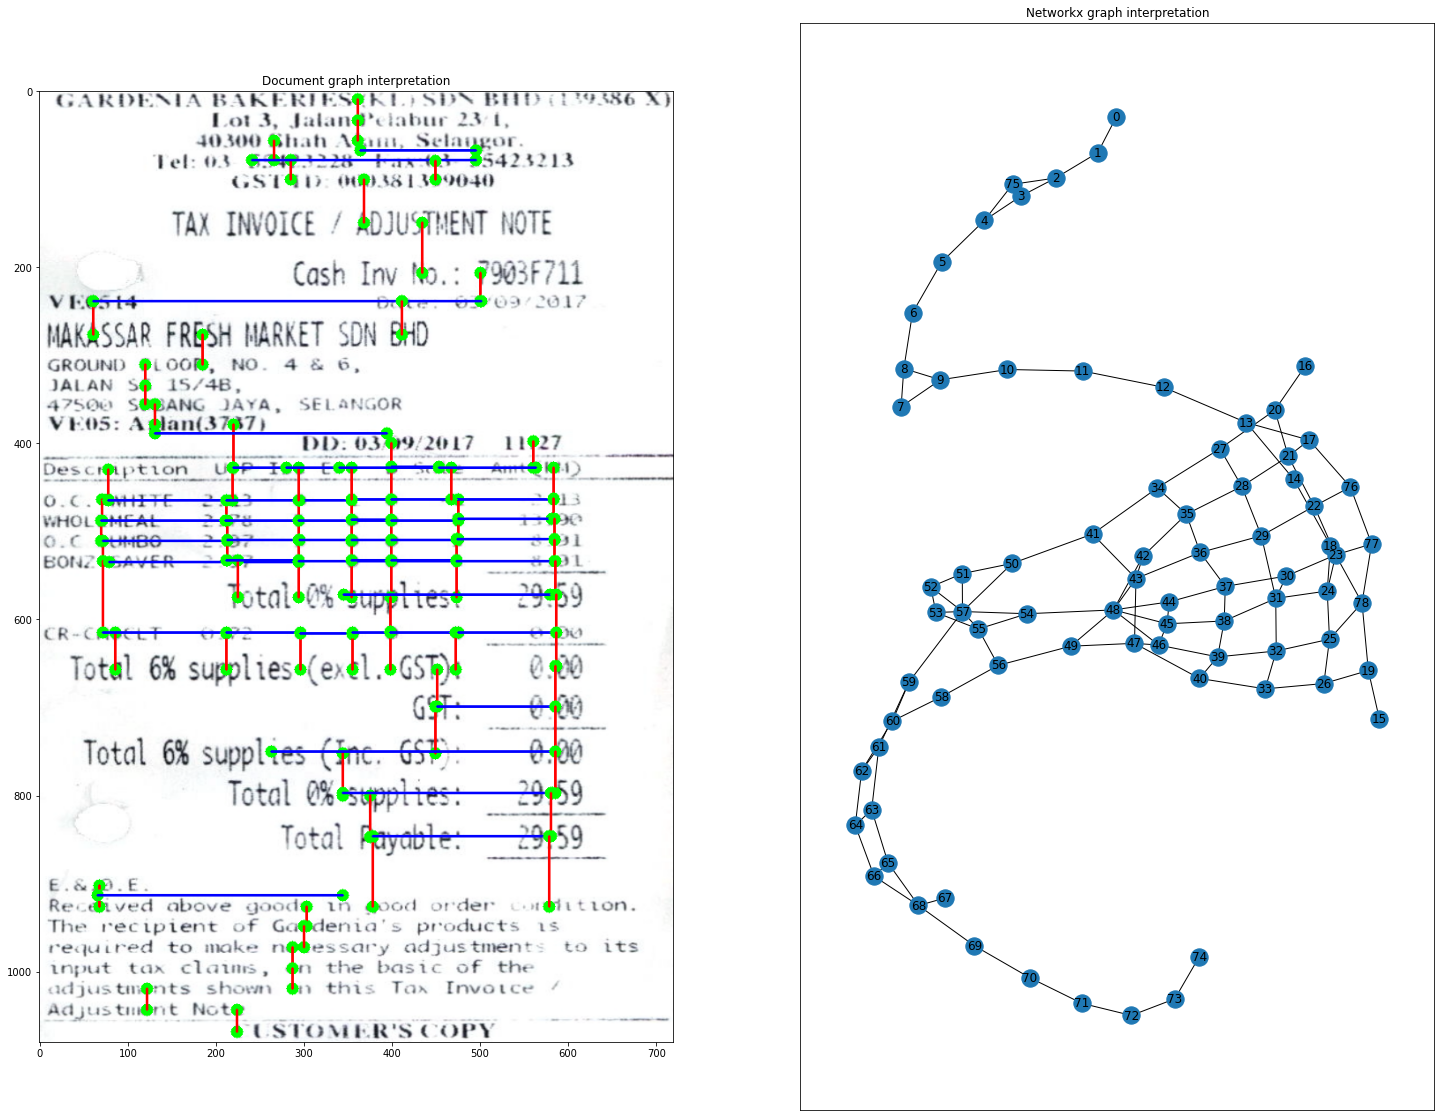

In [17]:
def plot_document_graph(df, g, resize=(conf.RESIZE_WIDTH, conf.RESIZE_HEIGHT)):
    assert df['image'].nunique() == 1, 'The plot is only for one document. Pass a df corresponding to only image/txt file.'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20))
    file_path, image_file = df['file_path'].unique()[0], df['image'].unique()[0]
    doc_xmin, doc_ymin, doc_xmax, doc_ymax = df['doc_xmin'].unique()[0], df['doc_ymin'].unique()[0], df['doc_xmax'].unique()[0], df['doc_ymax'].unique()[0]
    image = cv2.imread(os.path.join(file_path, image_file))
    image = image[doc_ymin: doc_ymax, doc_xmin: doc_xmax, :]
    image = cv2.resize(image, resize)
    for ind, row in df.iterrows():
        if row['vertically_close_object_ids'] != -1:
            image = cv2.circle(image, (int(row['vertically_close_object_x_src_coord_centroid']), int(row['vertically_close_object_y_src_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.circle(image, (int(row['vertically_close_object_x_dst_coord_centroid']), int(row['vertically_close_object_y_dst_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.line(image, (int(row['vertically_close_object_x_src_coord_centroid']), int(row['vertically_close_object_y_src_coord_centroid'])), (int(row['vertically_close_object_x_dst_coord_centroid']), int(row['vertically_close_object_y_dst_coord_centroid'])), color=(255, 0, 0), thickness=2)
        if row['horizontally_close_object_ids'] != -1:
            image = cv2.circle(image, (int(row['horizontally_close_object_x_src_coord_centroid']), int(row['horizontally_close_object_y_src_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.circle(image, (int(row['horizontally_close_object_x_dst_coord_centroid']), int(row['horizontally_close_object_y_dst_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.line(image, (int(row['horizontally_close_object_x_src_coord_centroid']), int(row['horizontally_close_object_y_src_coord_centroid'])), (int(row['horizontally_close_object_x_dst_coord_centroid']), int(row['horizontally_close_object_y_dst_coord_centroid'])), color=(0, 0, 255), thickness=2)
    ax1.imshow(image)
    ax1.set_title('Document graph interpretation')
    ax2.set_title('Networkx graph interpretation')
    nx.draw_networkx(g, ax=ax2)

plot_document_graph(__df__, __graph__)

In [18]:
ce_weights = np.asarray([1 - (i / len(df_dataset)) for i in list(df_dataset['label'].value_counts().sort_index())])
ce_weights

array([0.14299689, 0.95310162, 0.97859362, 0.97741397, 0.94789389])

In [19]:
def plot_graph(g, ind):
    figure = plt.figure(figsize=(15, 15))
    plt.title(f'Graph for data point at index {ind}')
    nx.draw_networkx(g)
    
def create_graph_dataset(df):
    graphs, dataset = [], []
    docs = list(df['image'].unique())
    for doc in tqdm(docs):
        _, _, graph, _, _, _, _, _, data = Graph(df[df['image']==doc]).graph()
        graphs.append(graph)
        dataset.append(data)
    return graphs, dataset

graphs, dataset = create_graph_dataset(df_dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [01:58<00:00,  5.48it/s]


Count of valid and cleaned data = 650


Data(x=[34, 51], edge_index=[2, 74], y=[34])

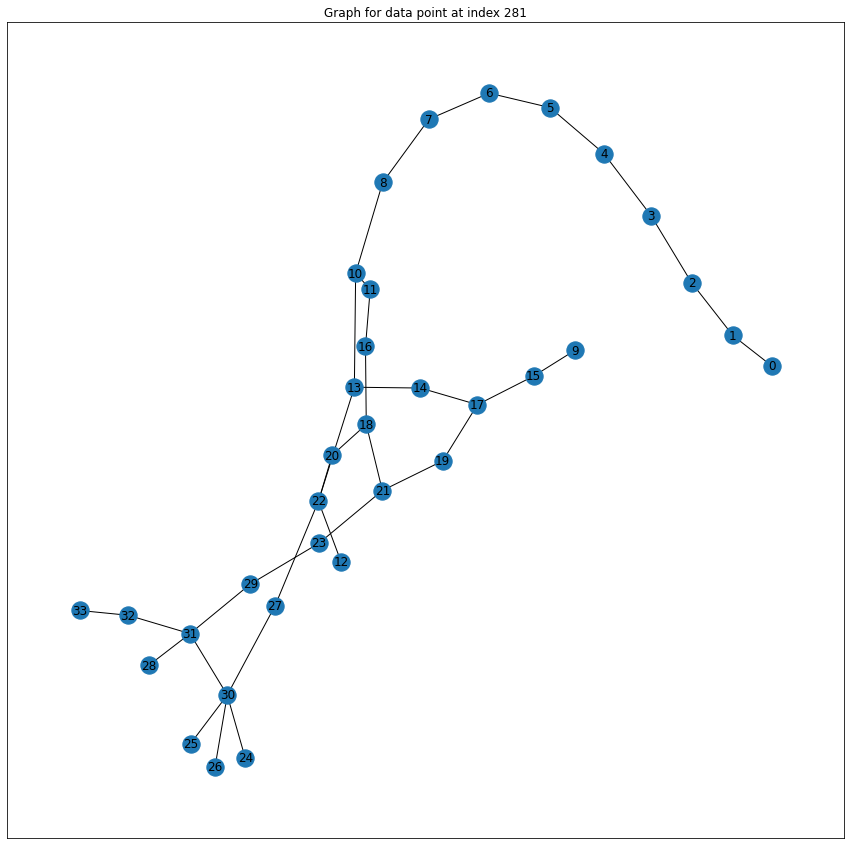

In [20]:
ind = random.choice(np.arange(0, len(graphs)))
plot_graph(graphs[ind], ind)
print('Count of valid and cleaned data =', len(dataset))
dataset[ind]

In [21]:
def get_data_module(dataset, val_split=conf.VAL_SPLIT, test_split=conf.TEST_SPLIT, batch_size=conf.BATCH_SIZE, random_seed=42):
    random.seed(random_seed)
    random.shuffle(dataset)
    dataset_length = len(dataset)
    train_dataset = dataset[: int(dataset_length * (1 - (val_split + test_split)))]
    val_dataset = dataset[int(dataset_length * (1 - (val_split + test_split))): int(dataset_length * (1 - val_split))]
    test_dataset = dataset[int(dataset_length * (1 - val_split)): ]
    return train_dataset, val_dataset, test_dataset, G_LightningDataset(train_dataset, val_dataset, test_dataset, batch_size)

train_dataset, val_dataset, test_dataset, data_module = get_data_module(dataset)

## Model Definition and Training

In [22]:
def visualize_tsne(h, color, n_components=2):
    if isinstance(h, np.ndarray):
        z = TSNE(n_components=n_components).fit_transform(h)
    else:
        z = TSNE(n_components=n_components).fit_transform(h.detach().cpu().numpy())       
    plt.figure(figsize=(10, 10))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('TSNE for GCN output')
    plt.scatter(z[:, 0], z[:, 1], s=75, c=color, cmap='Set1')
    plt.show()

In [23]:
class GCN(torch.nn.Module):
    
    def __init__(self, num_features, num_classes, is_spectral=False, K=3, dropout=0.2, torch_seed=42):
        super().__init__()
        torch.manual_seed(torch_seed)
        self.dropout=dropout
        if is_spectral:
            self.conv1 = ChebConv(num_features, 32, K=K)
            self.conv2 = ChebConv(32, 16, K=K)
            self.conv3 = ChebConv(16, num_classes, K=K)
        else:
            self.conv1 = GCNConv(num_features, 32, improved=True)
            self.conv2 = GCNConv(32, 16, improved=True)
            self.conv3 = GCNConv(16, num_classes, improved=True)

    def forward(self, x, edge_index):
        x = F.dropout(self.conv1(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = F.dropout(self.conv2(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = F.log_softmax(self.conv3(x, edge_index), dim=1)
        return x

GCN(
  (conv1): GCNConv(51, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 5)
)
Model output shape =  torch.Size([79, 5])


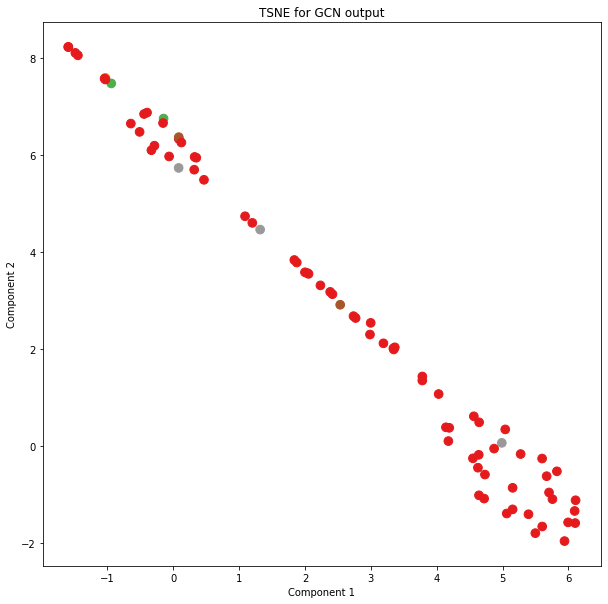

In [24]:
__model__ = GCN(num_features=51, num_classes=len(conf.LABEL))
print(__model__)
__model__.eval()
__out__ = __model__(__data__.x, __data__.edge_index)
print('Model output shape = ', __out__.size())
visualize_tsne(__out__, color=__data__.y)

GCN(
  (conv1): ChebConv(51, 32, K=3, normalization=sym)
  (conv2): ChebConv(32, 16, K=3, normalization=sym)
  (conv3): ChebConv(16, 5, K=3, normalization=sym)
)
Model output shape =  torch.Size([79, 5])


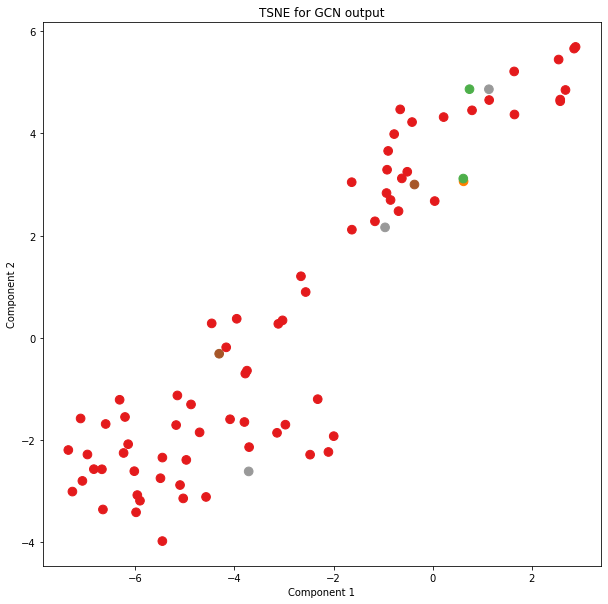

In [25]:
__model__ = GCN(num_features=51, num_classes=len(conf.LABEL), is_spectral=True)
print(__model__)
__model__.eval()
__out__ = __model__(__data__.x, __data__.edge_index)
print('Model output shape = ', __out__.size())
visualize_tsne(__out__, color=__data__.y)

In [26]:
class LitGCN(pl.LightningModule):

    def __init__(self, ce_weights, is_spectral=False, num_features=51, num_classes=5, batch_size=128, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__()
        self.ce_weights = ce_weights
        self.criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(ce_weights).float())
        self.model = GCN(num_features=num_features, num_classes=num_classes, is_spectral=is_spectral)
        self.learning_rate=learning_rate
        self.batch_size = batch_size
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def forward(self, x, edge_index):
        return self.model(x, edge_index)

    def training_step(self, train_batch, batch_idx):
        data = train_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def on_train_end(self, *args, **kwargs):
        self.logger.experiment.add_graph(LitGCN(ce_weights=self.ce_weights), [torch.randn((69, 51)), torch.randint(0, 69, (2, 100)).type(torch.LongTensor)])
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)

    def validation_step(self, val_batch, batch_idx):
        data = val_batch
        y_hat = self.forward(data.x, data.edge_index)   
        with torch.autocast('cuda'):
            loss = self.criterion(y_hat, data.y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        data = test_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate, 
            betas=self.betas, 
            eps=self.eps, 
            weight_decay=self.weight_decay
        )
        cyclic_lr_scheduler = {
            "scheduler": CyclicLR(
                optimizer=optimizer,
                base_lr=self.learning_rate,
                max_lr=1e-6,
                cycle_momentum=False # False with AdamW
            ),
            "interval": "step"
        }
        return [optimizer], [cyclic_lr_scheduler]
    
    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        items.pop("loss", None)
        return items

In [27]:
def test_model(ckpt, ce_weights, demo_data, root=conf.MODEL_SAVED_PATH, is_spectral=False):
    model = LitGCN.load_from_checkpoint(checkpoint_path=root + ckpt, ce_weights=ce_weights, is_spectral=is_spectral)
    model.eval()
    out = model(demo_data.x, demo_data.edge_index)
    print('Model output shape = ', out.size())
    visualize_tsne(out, color=demo_data.y)
    df_model_res = {
        'pred_label': [],
        'true_label': []
    }
    for test_data in test_dataset:
        y_hat = model(test_data.x, test_data.edge_index)
        y_hat = y_hat.cpu().detach().numpy()
        y_hat = np.argmax(y_hat, axis=1)
        y = test_data.y.cpu().detach().numpy()
        for i in range(len(y)):
            df_model_res['pred_label'].append(y_hat[i])
            df_model_res['true_label'].append(y[i])
    df_model_res = pd.DataFrame.from_dict(df_model_res)
    print(classification_report(df_model_res['pred_label'], df_model_res['true_label']))
    return df_model_res

### Spatial GCN

/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
Finding best initial lr: 100%|█████████████████████████████

CPU times: user 10.5 s, sys: 22.6 ms, total: 10.6 s
Wall time: 2.68 s


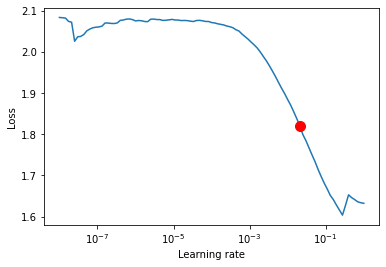

In [28]:
%%time
model_spatial = LitGCN(ce_weights=ce_weights)
trainer_spatial = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, progress_bar_refresh_rate=0, default_root_dir=conf.MODEL_SAVED_PATH+'/temp')
lr_finder_spatial = trainer_spatial.tuner.lr_find(model_spatial, data_module)
fig = lr_finder_spatial.plot(suggest=True)
fig.show()

In [29]:
%%time
trainer_spatial = pl.Trainer(default_root_dir=conf.MODEL_SAVED_PATH,
                             precision=32,
                             limit_train_batches=0.5,
                             gpus=1 if torch.cuda.is_available() else None, 
                             max_epochs=conf.EPOCHS,
                             logger=TensorBoardLogger(conf.MODEL_SAVED_PATH, name='spatial_gcn'),
                             callbacks=[
                                    LearningRateMonitor(logging_interval="step"), 
                                    ModelCheckpoint(monitor="train_loss"),
                                ],
                             # resume_from_checkpoint=conf.MODEL_SAVED_PATH + '/' +'spatial_gcn' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                             )

trainer_spatial.fit(LitGCN(ce_weights=ce_weights), data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
Missing logger folder: ../../../runs/models/spatial_gcn

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | GCN              | 2.3 K 
-----------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 0:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:00<00:00, 24.16it/s]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                                                                                      | 0/1 [00:00<?, ?it/s]

2022-01-31 20:25:32.248074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/cv2/../../lib64:
2022-01-31 20:25:32.248113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:00<00:00, 28.74it/s, val_loss=1.840, train_loss=2.050]
Validating: 0it [00:00, ?it/s]
Epoch 2:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:00<00:00, 27.91it/s, val_loss=1.730, train_loss=1.920]
Validating: 0it [00:00, ?it/s]
Epoch 3:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:00<00:00, 21.39it/s, val_loss=1.650, train_loss=1.810]
Validating: 0it [00:00, ?it/s]
Epoch 4:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:00<00:00, 23.74it/s, val_loss=1.590, train_loss=1.750]
Validating: 0it [00:00, ?it/s]
Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████                            

Epoch 20:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 24.96it/s, val_loss=1.270, train_loss=1.330]
Validating: 0it [00:00, ?it/s]
Epoch 21:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 31.65it/s, val_loss=1.250, train_loss=1.330]
Validating: 0it [00:00, ?it/s]
Epoch 22:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 28.69it/s, val_loss=1.240, train_loss=1.320]
Validating: 0it [00:00, ?it/s]
Epoch 23:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 27.30it/s, val_loss=1.220, train_loss=1.290]
Validating: 0it [00:00, ?it/s]
Epoch 24:  67%|█████████████████████████████████████████████████████████████████████████▎                           

Validating: 0it [00:00, ?it/s]
Epoch 40:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 30.98it/s, val_loss=1.010, train_loss=1.080]
Validating: 0it [00:00, ?it/s]
Epoch 41:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 30.92it/s, val_loss=1.000, train_loss=1.080]
Validating: 0it [00:00, ?it/s]
Epoch 42:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 29.05it/s, val_loss=0.993, train_loss=1.080]
Validating: 0it [00:00, ?it/s]
Epoch 43:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 27.09it/s, val_loss=0.983, train_loss=1.030]
Validating: 0it [00:00, ?it/s]
Epoch 44:  67%|██████████████████████████████████████████████████████████████████████

Epoch 59:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 28.67it/s, val_loss=0.855, train_loss=0.931]
Validating: 0it [00:00, ?it/s]
Epoch 60:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 29.57it/s, val_loss=0.848, train_loss=0.929]
Validating: 0it [00:00, ?it/s]
Epoch 61:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 26.36it/s, val_loss=0.842, train_loss=0.892]
Validating: 0it [00:00, ?it/s]
Epoch 62:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 27.41it/s, val_loss=0.837, train_loss=0.908]
Validating: 0it [00:00, ?it/s]
Epoch 63:  67%|█████████████████████████████████████████████████████████████████████████▎                           

Epoch 78:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 28.43it/s, val_loss=0.765, train_loss=0.845]
Validating: 0it [00:00, ?it/s]
Epoch 79:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 28.93it/s, val_loss=0.761, train_loss=0.830]
Validating: 0it [00:00, ?it/s]
Epoch 80:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 26.43it/s, val_loss=0.758, train_loss=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 81:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 30.03it/s, val_loss=0.754, train_loss=0.837]
Validating: 0it [00:00, ?it/s]
Epoch 82:  67%|█████████████████████████████████████████████████████████████████████████▎                           

Validating: 0it [00:00, ?it/s]
Epoch 98:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 30.17it/s, val_loss=0.707, train_loss=0.773]
Validating: 0it [00:00, ?it/s]
Epoch 99:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 25.53it/s, val_loss=0.704, train_loss=0.771]
Validating: 0it [00:00, ?it/s]
Epoch 100:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.66it/s, val_loss=0.702, train_loss=0.796]
Validating: 0it [00:00, ?it/s]
Epoch 101:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 25.96it/s, val_loss=0.701, train_loss=0.777]
Validating: 0it [00:00, ?it/s]
Epoch 102:  67%|█████████████████████████████████████████████████████████████████████

Epoch 117:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.49it/s, val_loss=0.661, train_loss=0.728]
Validating: 0it [00:00, ?it/s]
Epoch 118:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.52it/s, val_loss=0.659, train_loss=0.727]
Validating: 0it [00:00, ?it/s]
Epoch 119:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.40it/s, val_loss=0.657, train_loss=0.721]
Validating: 0it [00:00, ?it/s]
Epoch 120:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.94it/s, val_loss=0.656, train_loss=0.737]
Validating: 0it [00:00, ?it/s]
Epoch 121:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 136:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.66it/s, val_loss=0.627, train_loss=0.725]
Validating: 0it [00:00, ?it/s]
Epoch 137:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.03it/s, val_loss=0.625, train_loss=0.713]
Validating: 0it [00:00, ?it/s]
Epoch 138:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.60it/s, val_loss=0.623, train_loss=0.694]
Validating: 0it [00:00, ?it/s]
Epoch 139:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.45it/s, val_loss=0.622, train_loss=0.705]
Validating: 0it [00:00, ?it/s]
Epoch 140:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 156:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.39it/s, val_loss=0.597, train_loss=0.674]
Validating: 0it [00:00, ?it/s]
Epoch 157:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.04it/s, val_loss=0.595, train_loss=0.653]
Validating: 0it [00:00, ?it/s]
Epoch 158:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.48it/s, val_loss=0.594, train_loss=0.678]
Validating: 0it [00:00, ?it/s]
Epoch 159:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.35it/s, val_loss=0.592, train_loss=0.685]
Validating: 0it [00:00, ?it/s]
Epoch 160:  67%|█████████████████████████████████████████████████████████████████████

Epoch 175:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 25.83it/s, val_loss=0.576, train_loss=0.646]
Validating: 0it [00:00, ?it/s]
Epoch 176:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.29it/s, val_loss=0.575, train_loss=0.656]
Validating: 0it [00:00, ?it/s]
Epoch 177:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.79it/s, val_loss=0.574, train_loss=0.646]
Validating: 0it [00:00, ?it/s]
Epoch 178:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.01it/s, val_loss=0.572, train_loss=0.638]
Validating: 0it [00:00, ?it/s]
Epoch 179:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 194:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.71it/s, val_loss=0.562, train_loss=0.641]
Validating: 0it [00:00, ?it/s]
Epoch 195:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.76it/s, val_loss=0.561, train_loss=0.657]
Validating: 0it [00:00, ?it/s]
Epoch 196:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.55it/s, val_loss=0.560, train_loss=0.606]
Validating: 0it [00:00, ?it/s]
Epoch 197:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.74it/s, val_loss=0.560, train_loss=0.623]
Validating: 0it [00:00, ?it/s]
Epoch 198:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 214:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.96it/s, val_loss=0.549, train_loss=0.610]
Validating: 0it [00:00, ?it/s]
Epoch 215:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.96it/s, val_loss=0.549, train_loss=0.615]
Validating: 0it [00:00, ?it/s]
Epoch 216:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.51it/s, val_loss=0.549, train_loss=0.642]
Validating: 0it [00:00, ?it/s]
Epoch 217:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.38it/s, val_loss=0.549, train_loss=0.632]
Validating: 0it [00:00, ?it/s]
Epoch 218:  67%|█████████████████████████████████████████████████████████████████████

Epoch 233:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 32.09it/s, val_loss=0.540, train_loss=0.604]
Validating: 0it [00:00, ?it/s]
Epoch 234:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.81it/s, val_loss=0.540, train_loss=0.624]
Validating: 0it [00:00, ?it/s]
Epoch 235:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.29it/s, val_loss=0.539, train_loss=0.601]
Validating: 0it [00:00, ?it/s]
Epoch 236:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.21it/s, val_loss=0.538, train_loss=0.587]
Validating: 0it [00:00, ?it/s]
Epoch 237:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 252:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.27it/s, val_loss=0.531, train_loss=0.598]
Validating: 0it [00:00, ?it/s]
Epoch 253:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.91it/s, val_loss=0.531, train_loss=0.580]
Validating: 0it [00:00, ?it/s]
Epoch 254:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.02it/s, val_loss=0.531, train_loss=0.629]
Validating: 0it [00:00, ?it/s]
Epoch 255:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.71it/s, val_loss=0.532, train_loss=0.603]
Validating: 0it [00:00, ?it/s]
Epoch 256:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 272:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.98it/s, val_loss=0.526, train_loss=0.600]
Validating: 0it [00:00, ?it/s]
Epoch 273:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.97it/s, val_loss=0.526, train_loss=0.604]
Validating: 0it [00:00, ?it/s]
Epoch 274:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.90it/s, val_loss=0.527, train_loss=0.569]
Validating: 0it [00:00, ?it/s]
Epoch 275:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.86it/s, val_loss=0.527, train_loss=0.613]
Validating: 0it [00:00, ?it/s]
Epoch 276:  67%|█████████████████████████████████████████████████████████████████████

Epoch 291:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.58it/s, val_loss=0.522, train_loss=0.567]
Validating: 0it [00:00, ?it/s]
Epoch 292:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.34it/s, val_loss=0.521, train_loss=0.587]
Validating: 0it [00:00, ?it/s]
Epoch 293:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.76it/s, val_loss=0.522, train_loss=0.572]
Validating: 0it [00:00, ?it/s]
Epoch 294:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.47it/s, val_loss=0.522, train_loss=0.584]
Validating: 0it [00:00, ?it/s]
Epoch 295:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 310:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.45it/s, val_loss=0.516, train_loss=0.560]
Validating: 0it [00:00, ?it/s]
Epoch 311:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.91it/s, val_loss=0.516, train_loss=0.581]
Validating: 0it [00:00, ?it/s]
Epoch 312:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.21it/s, val_loss=0.516, train_loss=0.570]
Validating: 0it [00:00, ?it/s]
Epoch 313:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.05it/s, val_loss=0.516, train_loss=0.575]
Validating: 0it [00:00, ?it/s]
Epoch 314:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 330:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.72it/s, val_loss=0.512, train_loss=0.550]
Validating: 0it [00:00, ?it/s]
Epoch 331:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.40it/s, val_loss=0.512, train_loss=0.564]
Validating: 0it [00:00, ?it/s]
Epoch 332:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.14it/s, val_loss=0.513, train_loss=0.578]
Validating: 0it [00:00, ?it/s]
Epoch 333:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.26it/s, val_loss=0.513, train_loss=0.594]
Validating: 0it [00:00, ?it/s]
Epoch 334:  67%|█████████████████████████████████████████████████████████████████████

Epoch 349:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 25.50it/s, val_loss=0.508, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 350:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.48it/s, val_loss=0.508, train_loss=0.568]
Validating: 0it [00:00, ?it/s]
Epoch 351:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 24.93it/s, val_loss=0.509, train_loss=0.558]
Validating: 0it [00:00, ?it/s]
Epoch 352:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.28it/s, val_loss=0.509, train_loss=0.578]
Validating: 0it [00:00, ?it/s]
Epoch 353:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 368:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.08it/s, val_loss=0.504, train_loss=0.559]
Validating: 0it [00:00, ?it/s]
Epoch 369:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.97it/s, val_loss=0.504, train_loss=0.577]
Validating: 0it [00:00, ?it/s]
Epoch 370:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.41it/s, val_loss=0.504, train_loss=0.557]
Validating: 0it [00:00, ?it/s]
Epoch 371:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.91it/s, val_loss=0.504, train_loss=0.576]
Validating: 0it [00:00, ?it/s]
Epoch 372:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 388:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.36it/s, val_loss=0.502, train_loss=0.549]
Validating: 0it [00:00, ?it/s]
Epoch 389:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.55it/s, val_loss=0.501, train_loss=0.538]
Validating: 0it [00:00, ?it/s]
Epoch 390:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.64it/s, val_loss=0.501, train_loss=0.553]
Validating: 0it [00:00, ?it/s]
Epoch 391:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.25it/s, val_loss=0.500, train_loss=0.560]
Validating: 0it [00:00, ?it/s]
Epoch 392:  67%|█████████████████████████████████████████████████████████████████████

Epoch 407:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.01it/s, val_loss=0.498, train_loss=0.563]
Validating: 0it [00:00, ?it/s]
Epoch 408:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.83it/s, val_loss=0.499, train_loss=0.553]
Validating: 0it [00:00, ?it/s]
Epoch 409:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.50it/s, val_loss=0.499, train_loss=0.540]
Validating: 0it [00:00, ?it/s]
Epoch 410:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.65it/s, val_loss=0.499, train_loss=0.553]
Validating: 0it [00:00, ?it/s]
Epoch 411:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 426:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.97it/s, val_loss=0.497, train_loss=0.560]
Validating: 0it [00:00, ?it/s]
Epoch 427:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.43it/s, val_loss=0.497, train_loss=0.534]
Validating: 0it [00:00, ?it/s]
Epoch 428:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.91it/s, val_loss=0.496, train_loss=0.535]
Validating: 0it [00:00, ?it/s]
Epoch 429:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.18it/s, val_loss=0.495, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 430:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 446:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.73it/s, val_loss=0.494, train_loss=0.580]
Validating: 0it [00:00, ?it/s]
Epoch 447:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.00it/s, val_loss=0.493, train_loss=0.563]
Validating: 0it [00:00, ?it/s]
Epoch 448:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 24.32it/s, val_loss=0.493, train_loss=0.556]
Validating: 0it [00:00, ?it/s]
Epoch 449:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.11it/s, val_loss=0.493, train_loss=0.541]
Validating: 0it [00:00, ?it/s]
Epoch 450:  67%|█████████████████████████████████████████████████████████████████████

Epoch 465:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.35it/s, val_loss=0.491, train_loss=0.557]
Validating: 0it [00:00, ?it/s]
Epoch 466:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.67it/s, val_loss=0.492, train_loss=0.568]
Validating: 0it [00:00, ?it/s]
Epoch 467:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.63it/s, val_loss=0.492, train_loss=0.528]
Validating: 0it [00:00, ?it/s]
Epoch 468:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.34it/s, val_loss=0.491, train_loss=0.544]
Validating: 0it [00:00, ?it/s]
Epoch 469:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 484:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.33it/s, val_loss=0.489, train_loss=0.550]
Validating: 0it [00:00, ?it/s]
Epoch 485:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 32.25it/s, val_loss=0.489, train_loss=0.540]
Validating: 0it [00:00, ?it/s]
Epoch 486:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.08it/s, val_loss=0.489, train_loss=0.538]
Validating: 0it [00:00, ?it/s]
Epoch 487:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.64it/s, val_loss=0.489, train_loss=0.555]
Validating: 0it [00:00, ?it/s]
Epoch 488:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 504:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.38it/s, val_loss=0.488, train_loss=0.529]
Validating: 0it [00:00, ?it/s]
Epoch 505:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.80it/s, val_loss=0.488, train_loss=0.536]
Validating: 0it [00:00, ?it/s]
Epoch 506:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.29it/s, val_loss=0.488, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 507:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.23it/s, val_loss=0.487, train_loss=0.545]
Validating: 0it [00:00, ?it/s]
Epoch 508:  67%|█████████████████████████████████████████████████████████████████████

Epoch 523:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.57it/s, val_loss=0.485, train_loss=0.526]
Validating: 0it [00:00, ?it/s]
Epoch 524:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.02it/s, val_loss=0.486, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 525:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 25.99it/s, val_loss=0.487, train_loss=0.534]
Validating: 0it [00:00, ?it/s]
Epoch 526:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.87it/s, val_loss=0.487, train_loss=0.545]
Validating: 0it [00:00, ?it/s]
Epoch 527:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 542:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.32it/s, val_loss=0.483, train_loss=0.531]
Validating: 0it [00:00, ?it/s]
Epoch 543:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.92it/s, val_loss=0.483, train_loss=0.541]
Validating: 0it [00:00, ?it/s]
Epoch 544:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.66it/s, val_loss=0.483, train_loss=0.547]
Validating: 0it [00:00, ?it/s]
Epoch 545:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.76it/s, val_loss=0.483, train_loss=0.549]
Validating: 0it [00:00, ?it/s]
Epoch 546:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 562:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.34it/s, val_loss=0.483, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 563:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.86it/s, val_loss=0.483, train_loss=0.561]
Validating: 0it [00:00, ?it/s]
Epoch 564:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.15it/s, val_loss=0.482, train_loss=0.543]
Validating: 0it [00:00, ?it/s]
Epoch 565:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.97it/s, val_loss=0.482, train_loss=0.527]
Validating: 0it [00:00, ?it/s]
Epoch 566:  67%|█████████████████████████████████████████████████████████████████████

Epoch 581:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.44it/s, val_loss=0.481, train_loss=0.529]
Validating: 0it [00:00, ?it/s]
Epoch 582:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 32.12it/s, val_loss=0.482, train_loss=0.543]
Validating: 0it [00:00, ?it/s]
Epoch 583:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.37it/s, val_loss=0.482, train_loss=0.524]
Validating: 0it [00:00, ?it/s]
Epoch 584:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.68it/s, val_loss=0.482, train_loss=0.537]
Validating: 0it [00:00, ?it/s]
Epoch 585:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 600:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.25it/s, val_loss=0.480, train_loss=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 601:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.78it/s, val_loss=0.481, train_loss=0.517]
Validating: 0it [00:00, ?it/s]
Epoch 602:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.75it/s, val_loss=0.481, train_loss=0.541]
Validating: 0it [00:00, ?it/s]
Epoch 603:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.51it/s, val_loss=0.481, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 604:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 620:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.22it/s, val_loss=0.478, train_loss=0.528]
Validating: 0it [00:00, ?it/s]
Epoch 621:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.90it/s, val_loss=0.479, train_loss=0.528]
Validating: 0it [00:00, ?it/s]
Epoch 622:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 25.51it/s, val_loss=0.479, train_loss=0.539]
Validating: 0it [00:00, ?it/s]
Epoch 623:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 25.35it/s, val_loss=0.480, train_loss=0.544]
Validating: 0it [00:00, ?it/s]
Epoch 624:  67%|█████████████████████████████████████████████████████████████████████

Epoch 639:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.12it/s, val_loss=0.478, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 640:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.12it/s, val_loss=0.478, train_loss=0.524]
Validating: 0it [00:00, ?it/s]
Epoch 641:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 31.54it/s, val_loss=0.478, train_loss=0.535]
Validating: 0it [00:00, ?it/s]
Epoch 642:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.50it/s, val_loss=0.478, train_loss=0.525]
Validating: 0it [00:00, ?it/s]
Epoch 643:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 658:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.28it/s, val_loss=0.475, train_loss=0.518]
Validating: 0it [00:00, ?it/s]
Epoch 659:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.97it/s, val_loss=0.475, train_loss=0.528]
Validating: 0it [00:00, ?it/s]
Epoch 660:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.48it/s, val_loss=0.475, train_loss=0.522]
Validating: 0it [00:00, ?it/s]
Epoch 661:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.30it/s, val_loss=0.476, train_loss=0.540]
Validating: 0it [00:00, ?it/s]
Epoch 662:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 678:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.86it/s, val_loss=0.475, train_loss=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 679:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 25.86it/s, val_loss=0.475, train_loss=0.512]
Validating: 0it [00:00, ?it/s]
Epoch 680:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.77it/s, val_loss=0.475, train_loss=0.499]
Validating: 0it [00:00, ?it/s]
Epoch 681:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.56it/s, val_loss=0.475, train_loss=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 682:  67%|█████████████████████████████████████████████████████████████████████

Epoch 697:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.61it/s, val_loss=0.475, train_loss=0.520]
Validating: 0it [00:00, ?it/s]
Epoch 698:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.97it/s, val_loss=0.475, train_loss=0.528]
Validating: 0it [00:00, ?it/s]
Epoch 699:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 28.21it/s, val_loss=0.475, train_loss=0.504]
Validating: 0it [00:00, ?it/s]
Epoch 700:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.87it/s, val_loss=0.475, train_loss=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 701:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 716:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 30.38it/s, val_loss=0.473, train_loss=0.511]
Validating: 0it [00:00, ?it/s]
Epoch 717:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.82it/s, val_loss=0.473, train_loss=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 718:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.00it/s, val_loss=0.473, train_loss=0.512]
Validating: 0it [00:00, ?it/s]
Epoch 719:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.41it/s, val_loss=0.473, train_loss=0.544]
Validating: 0it [00:00, ?it/s]
Epoch 720:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 736:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 26.65it/s, val_loss=0.474, train_loss=0.543]
Validating: 0it [00:00, ?it/s]
Epoch 737:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 29.05it/s, val_loss=0.474, train_loss=0.512]
Validating: 0it [00:00, ?it/s]
Epoch 738:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 27.74it/s, val_loss=0.473, train_loss=0.531]
Validating: 0it [00:00, ?it/s]
Epoch 739:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 20.76it/s, val_loss=0.473, train_loss=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 740:  67%|█████████████████████████████████████████████████████████████████████

/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning:

CPU times: user 4min 28s, sys: 1.92 s, total: 4min 30s
Wall time: 1min 11s


In [30]:
%%time
trainer_spatial.test(ckpt_path="best", datamodule=data_module)

/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
Restoring states from the checkpoint path at ../../../runs/models/spatial_gcn/version_0/checkpoints/epoch=745-step=1491.ckpt
Loaded model weights from checkpoint at ../../../runs/models/spatial_gcn/version_0/checkpoints/epoch=745-step=1491.ckpt


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4558143615722656}
--------------------------------------------------------------------------------
Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.10it/s]
CPU times: user 62.2 ms, sys: 3.89 ms, total: 66.1 ms
Wall time: 28 ms


[{'test_loss': 0.4558143615722656}]

Model output shape =  torch.Size([79, 5])


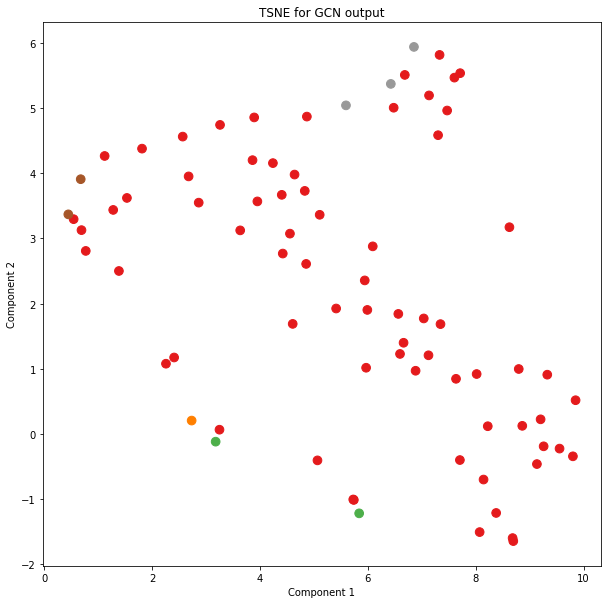

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      2482
           1       0.91      0.62      0.73       238
           2       0.90      0.56      0.69       126
           3       0.90      0.40      0.56       179
           4       0.77      0.23      0.36       548

    accuracy                           0.80      3573
   macro avg       0.85      0.56      0.64      3573
weighted avg       0.80      0.80      0.76      3573



In [31]:
res_spatial = test_model('/' +'spatial_gcn' +'/version_0/checkpoints/epoch=745-step=1491.ckpt', ce_weights, __data__)

In [32]:
print(classification_report(res_spatial[res_spatial['true_label'] != 0]['pred_label'], res_spatial[res_spatial['true_label'] != 0]['true_label']))
res_spatial[res_spatial['true_label'] != 0]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.91      0.97      0.94       152
           2       0.90      0.91      0.90        78
           3       0.90      0.99      0.94        73
           4       0.77      1.00      0.87       127

    accuracy                           0.86       487
   macro avg       0.69      0.77      0.73       487
weighted avg       0.76      0.86      0.80       487



pred_label  true_label
0              2           2
1              1           1
2              1           1
8              3           3
14             3           3
...          ...         ...
3559           4           4
3561           4           4
3563           4           4
3565           0           4
3571           0           4

[487 rows x 2 columns]

In [33]:
res_spatial[(res_spatial['true_label'] != res_spatial['pred_label']) & (res_spatial['true_label'] != 0)]

pred_label  true_label
332            0           4
386            0           1
466            0           4
490            0           1
544            2           1
...          ...         ...
3239           0           3
3255           0           4
3429           0           4
3565           0           4
3571           0           4

[70 rows x 2 columns]

<AxesSubplot:ylabel='Density'>

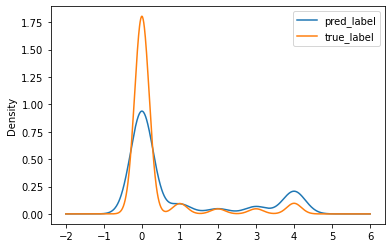

In [34]:
res_spatial.plot.kde()

### Spectral GCN

/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages

CPU times: user 28.7 s, sys: 34.6 ms, total: 28.7 s
Wall time: 7.24 s


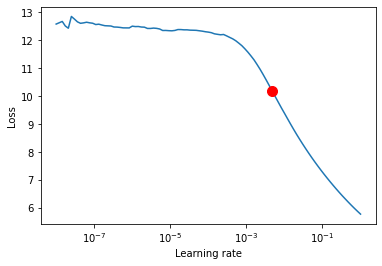

In [35]:
%%time
model_spectral = LitGCN(ce_weights=ce_weights, is_spectral=True)
trainer_spectral = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, progress_bar_refresh_rate=0, default_root_dir=conf.MODEL_SAVED_PATH+'/temp')
lr_finder_spectral = trainer_spectral.tuner.lr_find(model_spectral, data_module)
fig = lr_finder_spectral.plot(suggest=True)
fig.show()

In [36]:
%%time
trainer_spectral = pl.Trainer(default_root_dir=conf.MODEL_SAVED_PATH,
                             precision=32,
                             limit_train_batches=0.5,
                             gpus=1 if torch.cuda.is_available() else None, 
                             max_epochs=conf.EPOCHS,
                             logger=TensorBoardLogger(conf.MODEL_SAVED_PATH, name='spectral_gcn'),
                             callbacks=[
                                    LearningRateMonitor(logging_interval="step"), 
                                    ModelCheckpoint(monitor="train_loss"),
                                ],
                             # resume_from_checkpoint=conf.MODEL_SAVED_PATH + '/' +'spectral_gcn' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                             )

trainer_spectral.fit(LitGCN(ce_weights=ce_weights, is_spectral=True), data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: ../../../runs/models/spectral_gcn

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | GCN              | 6.7 K 
-----------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total estimated model params size (MB)


Epoch 0:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:00<00:00, 11.33it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:00<00:00,  9.48it/s, val_loss=7.410, train_loss=12.10]
Validating: 0it [00:00, ?it/s]
Epoch 2:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:00<00:00, 10.17it/s, val_loss=5.620, train_loss=9.370]
Validating: 0it [00:00, ?it/s]
Epoch 3:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:00<00:00, 10.49it/s, val_loss=4.280, train_loss=7.870]
Validating: 0it [00:00, ?it/s]
Epoch 4:  67%|██████████████████████████████████████████████████████████████████████████                            

Validating: 0it [00:00, ?it/s]
Epoch 20:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 12.37it/s, val_loss=1.390, train_loss=1.760]
Validating: 0it [00:00, ?it/s]
Epoch 21:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 10.50it/s, val_loss=1.370, train_loss=1.680]
Validating: 0it [00:00, ?it/s]
Epoch 22:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 12.39it/s, val_loss=1.360, train_loss=1.630]
Validating: 0it [00:00, ?it/s]
Epoch 23:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 11.33it/s, val_loss=1.340, train_loss=1.610]
Validating: 0it [00:00, ?it/s]
Epoch 24:  67%|██████████████████████████████████████████████████████████████████████

Epoch 39:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 11.56it/s, val_loss=1.190, train_loss=1.370]
Validating: 0it [00:00, ?it/s]
Epoch 40:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 12.03it/s, val_loss=1.180, train_loss=1.350]
Validating: 0it [00:00, ?it/s]
Epoch 41:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 10.59it/s, val_loss=1.170, train_loss=1.330]
Validating: 0it [00:00, ?it/s]
Epoch 42:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 11.77it/s, val_loss=1.160, train_loss=1.330]
Validating: 0it [00:00, ?it/s]
Epoch 43:  67%|█████████████████████████████████████████████████████████████████████████▎                           

Epoch 58:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 11.03it/s, val_loss=1.010, train_loss=1.210]
Validating: 0it [00:00, ?it/s]
Epoch 59:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 11.82it/s, val_loss=1.000, train_loss=1.170]
Validating: 0it [00:00, ?it/s]
Epoch 60:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 10.04it/s, val_loss=0.994, train_loss=1.180]
Validating: 0it [00:00, ?it/s]
Epoch 61:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 12.54it/s, val_loss=0.988, train_loss=1.160]
Validating: 0it [00:00, ?it/s]
Epoch 62:  67%|█████████████████████████████████████████████████████████████████████████▎                           

Validating: 0it [00:00, ?it/s]
Epoch 78:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 11.07it/s, val_loss=0.894, train_loss=1.090]
Validating: 0it [00:00, ?it/s]
Epoch 79:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 10.63it/s, val_loss=0.890, train_loss=1.100]
Validating: 0it [00:00, ?it/s]
Epoch 80:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 10.40it/s, val_loss=0.887, train_loss=1.070]
Validating: 0it [00:00, ?it/s]
Epoch 81:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 12.04it/s, val_loss=0.882, train_loss=1.070]
Validating: 0it [00:00, ?it/s]
Epoch 82:  67%|██████████████████████████████████████████████████████████████████████

Epoch 97:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 12.49it/s, val_loss=0.812, train_loss=0.999]
Validating: 0it [00:00, ?it/s]
Epoch 98:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 12.66it/s, val_loss=0.808, train_loss=0.985]
Validating: 0it [00:00, ?it/s]
Epoch 99:  67%|█████████████████████████████████████████████████████████████████████████▎                                    | 2/3 [00:00<00:00, 11.55it/s, val_loss=0.803, train_loss=0.988]
Validating: 0it [00:00, ?it/s]
Epoch 100:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.90it/s, val_loss=0.797, train_loss=0.963]
Validating: 0it [00:00, ?it/s]
Epoch 101:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 116:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.60it/s, val_loss=0.728, train_loss=0.910]
Validating: 0it [00:00, ?it/s]
Epoch 117:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.65it/s, val_loss=0.725, train_loss=0.913]
Validating: 0it [00:00, ?it/s]
Epoch 118:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.87it/s, val_loss=0.723, train_loss=0.947]
Validating: 0it [00:00, ?it/s]
Epoch 119:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.42it/s, val_loss=0.721, train_loss=0.894]
Validating: 0it [00:00, ?it/s]
Epoch 120:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 136:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.08it/s, val_loss=0.645, train_loss=0.824]
Validating: 0it [00:00, ?it/s]
Epoch 137:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.77it/s, val_loss=0.642, train_loss=0.833]
Validating: 0it [00:00, ?it/s]
Epoch 138:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.58it/s, val_loss=0.639, train_loss=0.827]
Validating: 0it [00:00, ?it/s]
Epoch 139:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.23it/s, val_loss=0.636, train_loss=0.848]
Validating: 0it [00:00, ?it/s]
Epoch 140:  67%|█████████████████████████████████████████████████████████████████████

Epoch 155:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.71it/s, val_loss=0.586, train_loss=0.790]
Validating: 0it [00:00, ?it/s]
Epoch 156:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.44it/s, val_loss=0.585, train_loss=0.777]
Validating: 0it [00:00, ?it/s]
Epoch 157:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.85it/s, val_loss=0.583, train_loss=0.794]
Validating: 0it [00:00, ?it/s]
Epoch 158:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.42it/s, val_loss=0.581, train_loss=0.763]
Validating: 0it [00:00, ?it/s]
Epoch 159:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 174:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.97it/s, val_loss=0.544, train_loss=0.741]
Validating: 0it [00:00, ?it/s]
Epoch 175:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.15it/s, val_loss=0.543, train_loss=0.740]
Validating: 0it [00:00, ?it/s]
Epoch 176:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.49it/s, val_loss=0.542, train_loss=0.708]
Validating: 0it [00:00, ?it/s]
Epoch 177:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.21it/s, val_loss=0.540, train_loss=0.721]
Validating: 0it [00:00, ?it/s]
Epoch 178:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 194:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.65it/s, val_loss=0.516, train_loss=0.696]
Validating: 0it [00:00, ?it/s]
Epoch 195:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.17it/s, val_loss=0.514, train_loss=0.654]
Validating: 0it [00:00, ?it/s]
Epoch 196:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.81it/s, val_loss=0.514, train_loss=0.678]
Validating: 0it [00:00, ?it/s]
Epoch 197:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.63it/s, val_loss=0.513, train_loss=0.680]
Validating: 0it [00:00, ?it/s]
Epoch 198:  67%|█████████████████████████████████████████████████████████████████████

Epoch 213:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.76it/s, val_loss=0.494, train_loss=0.646]
Validating: 0it [00:00, ?it/s]
Epoch 214:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.55it/s, val_loss=0.493, train_loss=0.644]
Validating: 0it [00:00, ?it/s]
Epoch 215:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.11it/s, val_loss=0.492, train_loss=0.635]
Validating: 0it [00:00, ?it/s]
Epoch 216:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.68it/s, val_loss=0.491, train_loss=0.666]
Validating: 0it [00:00, ?it/s]
Epoch 217:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 232:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.05it/s, val_loss=0.474, train_loss=0.636]
Validating: 0it [00:00, ?it/s]
Epoch 233:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.74it/s, val_loss=0.472, train_loss=0.632]
Validating: 0it [00:00, ?it/s]
Epoch 234:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.37it/s, val_loss=0.472, train_loss=0.630]
Validating: 0it [00:00, ?it/s]
Epoch 235:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.51it/s, val_loss=0.473, train_loss=0.633]
Validating: 0it [00:00, ?it/s]
Epoch 236:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 252:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.49it/s, val_loss=0.466, train_loss=0.633]
Validating: 0it [00:00, ?it/s]
Epoch 253:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.41it/s, val_loss=0.465, train_loss=0.621]
Validating: 0it [00:00, ?it/s]
Epoch 254:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.57it/s, val_loss=0.465, train_loss=0.603]
Validating: 0it [00:00, ?it/s]
Epoch 255:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.18it/s, val_loss=0.464, train_loss=0.607]
Validating: 0it [00:00, ?it/s]
Epoch 256:  67%|█████████████████████████████████████████████████████████████████████

Epoch 271:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.63it/s, val_loss=0.455, train_loss=0.601]
Validating: 0it [00:00, ?it/s]
Epoch 272:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.54it/s, val_loss=0.454, train_loss=0.606]
Validating: 0it [00:00, ?it/s]
Epoch 273:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.51it/s, val_loss=0.454, train_loss=0.600]
Validating: 0it [00:00, ?it/s]
Epoch 274:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.59it/s, val_loss=0.453, train_loss=0.597]
Validating: 0it [00:00, ?it/s]
Epoch 275:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 290:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.58it/s, val_loss=0.445, train_loss=0.589]
Validating: 0it [00:00, ?it/s]
Epoch 291:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.76it/s, val_loss=0.445, train_loss=0.566]
Validating: 0it [00:00, ?it/s]
Epoch 292:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.63it/s, val_loss=0.444, train_loss=0.566]
Validating: 0it [00:00, ?it/s]
Epoch 293:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.87it/s, val_loss=0.443, train_loss=0.575]
Validating: 0it [00:00, ?it/s]
Epoch 294:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 310:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.81it/s, val_loss=0.437, train_loss=0.556]
Validating: 0it [00:00, ?it/s]
Epoch 311:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.47it/s, val_loss=0.437, train_loss=0.576]
Validating: 0it [00:00, ?it/s]
Epoch 312:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.60it/s, val_loss=0.437, train_loss=0.556]
Validating: 0it [00:00, ?it/s]
Epoch 313:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.57it/s, val_loss=0.437, train_loss=0.555]
Validating: 0it [00:00, ?it/s]
Epoch 314:  67%|█████████████████████████████████████████████████████████████████████

Epoch 329:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  7.69it/s, val_loss=0.434, train_loss=0.566]
Validating: 0it [00:00, ?it/s]
Epoch 330:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.45it/s, val_loss=0.433, train_loss=0.535]
Validating: 0it [00:00, ?it/s]
Epoch 331:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.90it/s, val_loss=0.433, train_loss=0.571]
Validating: 0it [00:00, ?it/s]
Epoch 332:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.95it/s, val_loss=0.432, train_loss=0.543]
Validating: 0it [00:00, ?it/s]
Epoch 333:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 348:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  7.79it/s, val_loss=0.427, train_loss=0.535]
Validating: 0it [00:00, ?it/s]
Epoch 349:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.04it/s, val_loss=0.426, train_loss=0.533]
Validating: 0it [00:00, ?it/s]
Epoch 350:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  4.51it/s, val_loss=0.425, train_loss=0.553]
Validating: 0it [00:00, ?it/s]
Epoch 351:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  7.88it/s, val_loss=0.425, train_loss=0.522]
Validating: 0it [00:00, ?it/s]
Epoch 352:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 367:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.71it/s, val_loss=0.420, train_loss=0.544]
Validating: 0it [00:00, ?it/s]
Epoch 368:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.35it/s, val_loss=0.420, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 369:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.56it/s, val_loss=0.419, train_loss=0.563]
Validating: 0it [00:00, ?it/s]
Epoch 370:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.93it/s, val_loss=0.419, train_loss=0.558]
Validating: 0it [00:00, ?it/s]
Epoch 371:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 387:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.96it/s, val_loss=0.415, train_loss=0.537]
Validating: 0it [00:00, ?it/s]
Epoch 388:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.03it/s, val_loss=0.415, train_loss=0.542]
Validating: 0it [00:00, ?it/s]
Epoch 389:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.95it/s, val_loss=0.415, train_loss=0.515]
Validating: 0it [00:00, ?it/s]
Epoch 390:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.87it/s, val_loss=0.414, train_loss=0.556]
Validating: 0it [00:00, ?it/s]
Epoch 391:  67%|█████████████████████████████████████████████████████████████████████

Epoch 406:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.03it/s, val_loss=0.408, train_loss=0.525]
Validating: 0it [00:00, ?it/s]
Epoch 407:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.49it/s, val_loss=0.408, train_loss=0.488]
Validating: 0it [00:00, ?it/s]
Epoch 408:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  7.22it/s, val_loss=0.407, train_loss=0.501]
Validating: 0it [00:00, ?it/s]
Epoch 409:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.96it/s, val_loss=0.407, train_loss=0.512]
Validating: 0it [00:00, ?it/s]
Epoch 410:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 425:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.60it/s, val_loss=0.403, train_loss=0.524]
Validating: 0it [00:00, ?it/s]
Epoch 426:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.88it/s, val_loss=0.403, train_loss=0.501]
Validating: 0it [00:00, ?it/s]
Epoch 427:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.19it/s, val_loss=0.403, train_loss=0.520]
Validating: 0it [00:00, ?it/s]
Epoch 428:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.52it/s, val_loss=0.403, train_loss=0.490]
Validating: 0it [00:00, ?it/s]
Epoch 429:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 445:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.95it/s, val_loss=0.398, train_loss=0.485]
Validating: 0it [00:00, ?it/s]
Epoch 446:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.37it/s, val_loss=0.397, train_loss=0.492]
Validating: 0it [00:00, ?it/s]
Epoch 447:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.45it/s, val_loss=0.397, train_loss=0.488]
Validating: 0it [00:00, ?it/s]
Epoch 448:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.98it/s, val_loss=0.397, train_loss=0.530]
Validating: 0it [00:00, ?it/s]
Epoch 449:  67%|█████████████████████████████████████████████████████████████████████

Epoch 464:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.25it/s, val_loss=0.393, train_loss=0.476]
Validating: 0it [00:00, ?it/s]
Epoch 465:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.87it/s, val_loss=0.393, train_loss=0.448]
Validating: 0it [00:00, ?it/s]
Epoch 466:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.92it/s, val_loss=0.392, train_loss=0.474]
Validating: 0it [00:00, ?it/s]
Epoch 467:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.35it/s, val_loss=0.391, train_loss=0.515]
Validating: 0it [00:00, ?it/s]
Epoch 468:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 483:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.42it/s, val_loss=0.390, train_loss=0.488]
Validating: 0it [00:00, ?it/s]
Epoch 484:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.86it/s, val_loss=0.390, train_loss=0.460]
Validating: 0it [00:00, ?it/s]
Epoch 485:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.74it/s, val_loss=0.389, train_loss=0.494]
Validating: 0it [00:00, ?it/s]
Epoch 486:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.66it/s, val_loss=0.390, train_loss=0.508]
Validating: 0it [00:00, ?it/s]
Epoch 487:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 503:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.80it/s, val_loss=0.386, train_loss=0.519]
Validating: 0it [00:00, ?it/s]
Epoch 504:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.37it/s, val_loss=0.386, train_loss=0.484]
Validating: 0it [00:00, ?it/s]
Epoch 505:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.23it/s, val_loss=0.386, train_loss=0.466]
Validating: 0it [00:00, ?it/s]
Epoch 506:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.81it/s, val_loss=0.386, train_loss=0.464]
Validating: 0it [00:00, ?it/s]
Epoch 507:  67%|█████████████████████████████████████████████████████████████████████

Epoch 522:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.80it/s, val_loss=0.383, train_loss=0.475]
Validating: 0it [00:00, ?it/s]
Epoch 523:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.19it/s, val_loss=0.382, train_loss=0.464]
Validating: 0it [00:00, ?it/s]
Epoch 524:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.17it/s, val_loss=0.381, train_loss=0.475]
Validating: 0it [00:00, ?it/s]
Epoch 525:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.89it/s, val_loss=0.380, train_loss=0.452]
Validating: 0it [00:00, ?it/s]
Epoch 526:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 541:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.42it/s, val_loss=0.375, train_loss=0.498]
Validating: 0it [00:00, ?it/s]
Epoch 542:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.57it/s, val_loss=0.375, train_loss=0.471]
Validating: 0it [00:00, ?it/s]
Epoch 543:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.48it/s, val_loss=0.375, train_loss=0.490]
Validating: 0it [00:00, ?it/s]
Epoch 544:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.65it/s, val_loss=0.375, train_loss=0.459]
Validating: 0it [00:00, ?it/s]
Epoch 545:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 561:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.09it/s, val_loss=0.371, train_loss=0.462]
Validating: 0it [00:00, ?it/s]
Epoch 562:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.56it/s, val_loss=0.370, train_loss=0.462]
Validating: 0it [00:00, ?it/s]
Epoch 563:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.63it/s, val_loss=0.370, train_loss=0.445]
Validating: 0it [00:00, ?it/s]
Epoch 564:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.81it/s, val_loss=0.370, train_loss=0.481]
Validating: 0it [00:00, ?it/s]
Epoch 565:  67%|█████████████████████████████████████████████████████████████████████

Epoch 580:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.42it/s, val_loss=0.366, train_loss=0.450]
Validating: 0it [00:00, ?it/s]
Epoch 581:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.53it/s, val_loss=0.366, train_loss=0.470]
Validating: 0it [00:00, ?it/s]
Epoch 582:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.18it/s, val_loss=0.366, train_loss=0.439]
Validating: 0it [00:00, ?it/s]
Epoch 583:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.73it/s, val_loss=0.366, train_loss=0.440]
Validating: 0it [00:00, ?it/s]
Epoch 584:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 599:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.22it/s, val_loss=0.363, train_loss=0.449]
Validating: 0it [00:00, ?it/s]
Epoch 600:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  9.69it/s, val_loss=0.364, train_loss=0.449]
Validating: 0it [00:00, ?it/s]
Epoch 601:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.41it/s, val_loss=0.364, train_loss=0.464]
Validating: 0it [00:00, ?it/s]
Epoch 602:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.77it/s, val_loss=0.364, train_loss=0.432]
Validating: 0it [00:00, ?it/s]
Epoch 603:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 619:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.82it/s, val_loss=0.357, train_loss=0.443]
Validating: 0it [00:00, ?it/s]
Epoch 620:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.03it/s, val_loss=0.357, train_loss=0.424]
Validating: 0it [00:00, ?it/s]
Epoch 621:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.42it/s, val_loss=0.357, train_loss=0.460]
Validating: 0it [00:00, ?it/s]
Epoch 622:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.06it/s, val_loss=0.356, train_loss=0.423]
Validating: 0it [00:00, ?it/s]
Epoch 623:  67%|█████████████████████████████████████████████████████████████████████

Epoch 638:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.21it/s, val_loss=0.354, train_loss=0.427]
Validating: 0it [00:00, ?it/s]
Epoch 639:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.85it/s, val_loss=0.354, train_loss=0.442]
Validating: 0it [00:00, ?it/s]
Epoch 640:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.52it/s, val_loss=0.353, train_loss=0.447]
Validating: 0it [00:00, ?it/s]
Epoch 641:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.59it/s, val_loss=0.353, train_loss=0.440]
Validating: 0it [00:00, ?it/s]
Epoch 642:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 657:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.69it/s, val_loss=0.352, train_loss=0.449]
Validating: 0it [00:00, ?it/s]
Epoch 658:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.64it/s, val_loss=0.352, train_loss=0.439]
Validating: 0it [00:00, ?it/s]
Epoch 659:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.41it/s, val_loss=0.353, train_loss=0.428]
Validating: 0it [00:00, ?it/s]
Epoch 660:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.27it/s, val_loss=0.352, train_loss=0.431]
Validating: 0it [00:00, ?it/s]
Epoch 661:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 677:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.78it/s, val_loss=0.348, train_loss=0.423]
Validating: 0it [00:00, ?it/s]
Epoch 678:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.79it/s, val_loss=0.348, train_loss=0.416]
Validating: 0it [00:00, ?it/s]
Epoch 679:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.31it/s, val_loss=0.348, train_loss=0.428]
Validating: 0it [00:00, ?it/s]
Epoch 680:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 13.00it/s, val_loss=0.348, train_loss=0.462]
Validating: 0it [00:00, ?it/s]
Epoch 681:  67%|█████████████████████████████████████████████████████████████████████

Epoch 696:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 13.16it/s, val_loss=0.346, train_loss=0.448]
Validating: 0it [00:00, ?it/s]
Epoch 697:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 11.99it/s, val_loss=0.346, train_loss=0.399]
Validating: 0it [00:00, ?it/s]
Epoch 698:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.59it/s, val_loss=0.346, train_loss=0.419]
Validating: 0it [00:00, ?it/s]
Epoch 699:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.99it/s, val_loss=0.346, train_loss=0.418]
Validating: 0it [00:00, ?it/s]
Epoch 700:  67%|████████████████████████████████████████████████████████████████████████▋                           

Epoch 715:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.14it/s, val_loss=0.344, train_loss=0.426]
Validating: 0it [00:00, ?it/s]
Epoch 716:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.68it/s, val_loss=0.344, train_loss=0.418]
Validating: 0it [00:00, ?it/s]
Epoch 717:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 13.02it/s, val_loss=0.343, train_loss=0.423]
Validating: 0it [00:00, ?it/s]
Epoch 718:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 12.74it/s, val_loss=0.343, train_loss=0.418]
Validating: 0it [00:00, ?it/s]
Epoch 719:  67%|████████████████████████████████████████████████████████████████████████▋                           

Validating: 0it [00:00, ?it/s]
Epoch 735:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.55it/s, val_loss=0.342, train_loss=0.409]
Validating: 0it [00:00, ?it/s]
Epoch 736:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.94it/s, val_loss=0.341, train_loss=0.441]
Validating: 0it [00:00, ?it/s]
Epoch 737:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00, 10.01it/s, val_loss=0.341, train_loss=0.464]
Validating: 0it [00:00, ?it/s]
Epoch 738:  67%|████████████████████████████████████████████████████████████████████████▋                                    | 2/3 [00:00<00:00,  8.47it/s, val_loss=0.341, train_loss=0.428]
Validating: 0it [00:00, ?it/s]
Epoch 739:  67%|█████████████████████████████████████████████████████████████████████

/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)


In [37]:
%%time
trainer_spectral.test(ckpt_path="best", datamodule=data_module)

Restoring states from the checkpoint path at ../../../runs/models/spectral_gcn/version_0/checkpoints/epoch=732-step=1465.ckpt
Loaded model weights from checkpoint at ../../../runs/models/spectral_gcn/version_0/checkpoints/epoch=732-step=1465.ckpt


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3040367066860199}
--------------------------------------------------------------------------------
Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]
CPU times: user 143 ms, sys: 70 µs, total: 143 ms
Wall time: 49.3 ms


[{'test_loss': 0.3040367066860199}]

Model output shape =  torch.Size([79, 5])


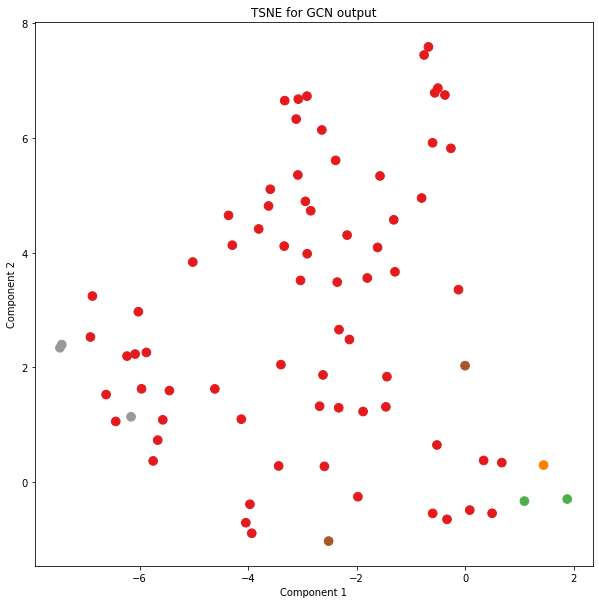

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2685
           1       0.96      0.65      0.77       241
           2       0.86      0.72      0.79        94
           3       0.99      0.80      0.88        99
           4       0.83      0.30      0.44       454

    accuracy                           0.86      3573
   macro avg       0.90      0.69      0.76      3573
weighted avg       0.86      0.86      0.84      3573



In [38]:
res_spectral = test_model('/' +'spectral_gcn' +'/version_0/checkpoints/epoch=732-step=1465.ckpt', ce_weights, __data__, is_spectral=True)

In [39]:
print(classification_report(res_spectral[res_spectral['true_label'] != 0]['pred_label'], res_spectral[res_spectral['true_label'] != 0]['true_label']))
res_spectral[res_spectral['true_label'] != 0]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.96      0.96      0.96       162
           2       0.86      0.99      0.92        69
           3       0.99      1.00      0.99        79
           4       0.83      0.99      0.90       138

    accuracy                           0.90       487
   macro avg       0.73      0.79      0.76       487
weighted avg       0.84      0.90      0.87       487



pred_label  true_label
0              2           2
1              1           1
2              1           1
8              3           3
14             3           3
...          ...         ...
3559           4           4
3561           4           4
3563           4           4
3565           4           4
3571           4           4

[487 rows x 2 columns]

In [40]:
res_spectral[(res_spectral['true_label'] != res_spectral['pred_label']) & (res_spectral['true_label'] != 0)]

pred_label  true_label
332            0           4
386            0           1
490            0           1
562            0           4
629            4           1
746            0           4
752            0           2
914            0           2
918            0           1
923            0           2
939            0           4
969            0           4
1043           0           4
1099           0           4
1545           0           3
1571           0           4
1592           2           1
1598           1           2
1635           0           4
1663           0           4
1894           1           2
1906           0           4
2001           1           2
2021           0           4
2035           0           4
2038           0           4
2257           1           2
2388           1           2
2810           0           4
2815           0           4
2856           0           4
2857           0           4
2863           0           4
2962           0           4
2968           0           4
2983           0           4
2985           0           4
3027           0           4
3028           0           4
3038           0           4
3072           1           2
3153           0           4
3166           0           2
3169           0           1
3255           0           4
3259           0           2
3429           0           4

<AxesSubplot:ylabel='Density'>

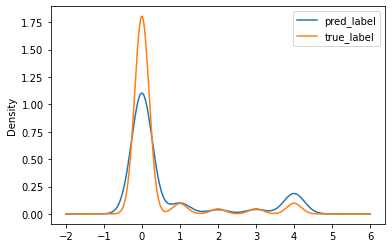

In [41]:
res_spectral.plot.kde()

<AxesSubplot:title={'center':'Spectral GCN'}, ylabel='Density'>

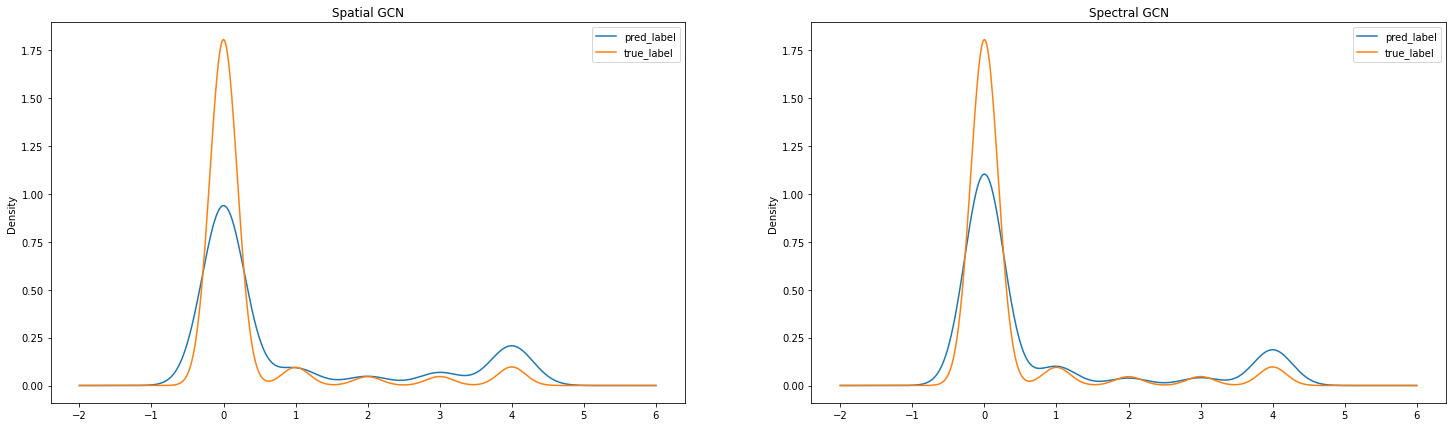

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,7))
ax1.set_title('Spatial GCN')
ax2.set_title('Spectral GCN')
res_spatial.plot(kind='kde', ax=ax1)
res_spectral.plot(kind='kde', ax=ax2)

## Model Inference - Post Deployment

In [43]:
df_ocr_processed

file_path               ie_file_path             image  \
0      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
1      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
2      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
3      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
4      ../../../data/raw/train-1  ../../../data/raw/train-2  X51005719917.jpg   
...                          ...                        ...               ...   
56891   ../../../data/raw/test-1                        NaN  X51009568881.jpg   
56892   ../../../data/raw/test-1                        NaN  X51009568881.jpg   
56893   ../../../data/raw/test-1                        NaN  X51009568881.jpg   
56894   ../../../data/raw/test-1                        NaN  X51009568881.jpg   
56895   ../../../data/raw/test-1                        NaN  X51009568881.jpg   

                    txt  width  height  normalized_width  normalized_height  \
0      X51005719917.txt    932    2679               767               2472   
1      X51005719917.txt    932    2679               767               2472   
2      X51005719917.txt    932    2679               767               2472   
3      X51005719917.txt    932    2679               767               2472   
4      X51005719917.txt    932    2679               767               2472   
...                 ...    ...     ...               ...                ...   
56891  X51009568881.txt    884    1678               769               1347   
56892  X51009568881.txt    884    1678               769               1347   
56893  X51009568881.txt    884    1678               769               1347   
56894  X51009568881.txt    884    1678               769               1347   
56895  X51009568881.txt    884    1678               769               1347   

       doc_xmin  doc_xmax  ...    n_r_y2    n_r_x3    n_r_y3    n_r_x4  \
0           101       868  ...  0.000000  0.621904  0.010922  0.349413   
1           101       868  ...  0.016990  0.658409  0.028722  0.320730   
2           101       868  ...  0.040049  0.816167  0.052994  0.168188   
3           101       868  ...  0.060680  0.786180  0.071602  0.183833   
4           101       868  ...  0.079693  0.857888  0.093851  0.121252   
...         ...       ...  ...       ...       ...       ...       ...   
56891        45       814  ...  0.874536  0.475943  0.896808  0.386216   
56892        45       814  ...  0.873794  0.706112  0.899035  0.615085   
56893        45       814  ...  0.874536  0.966190  0.898293  0.859558   
56894        45       814  ...  0.933927  0.958388  0.971789  0.006502   
56895        45       814  ...  0.974759  0.945384  1.000000  0.019506   

         n_r_y4  resize_width  resize_height  \
0      0.010922           720           1080   
1      0.028722           720           1080   
2      0.052994           720           1080   
3      0.071602           720           1080   
4      0.093851           720           1080   
...         ...           ...            ...   
56891  0.896808           720           1080   
56892  0.899035           720           1080   
56893  0.898293           720           1080   
56894  0.971789           720           1080   
56895  1.000000           720           1080   

                                                    text  label_names  label  
0                                            TAX INVOICE       OTHERS    0.0  
1                                         DOMINO'S PIZZA       OTHERS    0.0  
2                              GST REF NO : 001694261248       OTHERS    0.0  
3                                DOMINO'S PIZZA SEGAMBUT       OTHERS    0.0  
4                            D-08, M AVENUE, JLN 1 / 38A       OTHERS    0.0  
...                                                  ...          ...    ...  
56891                                               9.81          NaN    NaN  
568

In [50]:
def plot_record_inf(df):
    assert len(df['file_path'].unique().tolist()) == 1, 'df must have only one document.'
    image = cv2.imread(os.path.join(df.iloc[0]['file_path'], df.iloc[0]['image']))
    for ind, row in df.iterrows():
        if row['label_pred'] != conf.LABEL['OTHERS']:
            image = cv2.rectangle(image, (int(row['x1']), int(row['y1'])), (int(row['x3']), int(row['y3'])), (255, 0, 0), 2)
            image = cv2.putText(image, row['label_names_pred'], (int(row['x1']), int(row['y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            if isinstance(row['label_names'], str):
                image = cv2.putText(image, row['label_names'], (int(row['x2']), int(row['y2'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)            
    fig = plt.figure(figsize=(30,15))
    plt.imshow(image)

def inference(df, model, verbose=True):
    model.eval()
    inf_df = copy.deepcopy(df)
    inf_df, graph_dict, graph, padded_adj_matrix, padded_features, adj_matrix, edge_index, features, data = Graph(inf_df).graph()
    y_hat = model(data.x, data.edge_index)
    y_hat = y_hat.cpu().detach().numpy()
    out = copy.deepcopy(y_hat)
    y_hat = np.argmax(y_hat, axis=1)
    inf_df['label_pred'] = list(y_hat)
    inf_df['label_names_pred'] = inf_df['label_pred'].apply(lambda x: conf.IND_LABEL[str(x)])
    if verbose:
        visualize_tsne(out, y_hat)
        plot_document_graph(inf_df, graph)
        plot_record_inf(inf_df)
    return inf_df

In [45]:
test_with_labels_df_ocr_processed = copy.deepcopy(df_ocr_processed[df_ocr_processed['is_test_with_label'] == True])
test_with_labels_df_ocr_processed

file_path               ie_file_path             image  \
964    ../../../data/raw/train-1  ../../../data/raw/train-2  X51006713996.jpg   
965    ../../../data/raw/train-1  ../../../data/raw/train-2  X51006713996.jpg   
966    ../../../data/raw/train-1  ../../../data/raw/train-2  X51006713996.jpg   
967    ../../../data/raw/train-1  ../../../data/raw/train-2  X51006713996.jpg   
968    ../../../data/raw/train-1  ../../../data/raw/train-2  X51006713996.jpg   
...                          ...                        ...               ...   
23903  ../../../data/raw/train-1  ../../../data/raw/train-2  X51005447848.jpg   
23904  ../../../data/raw/train-1  ../../../data/raw/train-2  X51005447848.jpg   
23905  ../../../data/raw/train-1  ../../../data/raw/train-2  X51005447848.jpg   
23906  ../../../data/raw/train-1  ../../../data/raw/train-2  X51005447848.jpg   
23907  ../../../data/raw/train-1  ../../../data/raw/train-2  X51005447848.jpg   

                    txt  width  height  normalized_width  normalized_height  \
964    X51006713996.txt    731    1324               575               1257   
965    X51006713996.txt    731    1324               575               1257   
966    X51006713996.txt    731    1324               575               1257   
967    X51006713996.txt    731    1324               575               1257   
968    X51006713996.txt    731    1324               575               1257   
...                 ...    ...     ...               ...                ...   
23903  X51005447848.txt    932    1987               745               1771   
23904  X51005447848.txt    932    1987               745               1771   
23905  X51005447848.txt    932    1987               745               1771   
23906  X51005447848.txt    932    1987               745               1771   
23907  X51005447848.txt    932    1987               745               1771   

       doc_xmin  doc_xmax  ...    n_r_y2    n_r_x3    n_r_y3    n_r_x4  \
964          41       616  ...  0.000000  0.876522  0.025457  0.086957   
965          41       616  ...  0.030231  0.761739  0.051710  0.208696   
966          41       616  ...  0.056484  0.876522  0.080350  0.060870   
967          41       616  ...  0.082737  0.928696  0.110581  0.010435   
968          41       616  ...  0.114558  0.737391  0.139220  0.215652   
...         ...       ...  ...       ...       ...       ...       ...   
23903       106       851  ...  0.924901  0.191946  0.944664  0.006711   
23904       106       851  ...  0.926030  0.534228  0.941276  0.436242   
23905       106       851  ...  0.927160  0.824161  0.942970  0.746309   
23906       106       851  ...  0.961039  0.632215  0.976849  0.369128   
23907       106       851  ...  0.981931  0.739597  1.000000  0.261745   

         n_r_y4  resize_width  resize_height  \
964    0.025457           720           1080   
965    0.051710           720           1080   
966    0.080350           720           1080   
967    0.110581           720           1080   
968    0.139220           720           1080   
...         ...           ...            ...   
23903  0.944664           720           1080   
23904  0.941276           720           1080   
23905  0.942970           720           1080   
23906  0.976849           720           1080   
23907  1.000000           720           1080   

                                         text  label_names  label  
964          SKCA HARDWARE & TIMBER SDN. BHD.      COMPANY    2.0  
965                    CO. REG. NO.: 946207-D       OTHERS    0.0  
966        LOT 204 & 205, JALAN BATU 12 1/4,       ADDRESS    1.0  
967    KG. DUSUN NANDING, 43100 HULU LANGAT,       ADDRESS    1.0  
968                     SELANGOR DARUL EHSAN.      ADDRESS    1.0  
...                                       ...          ...    ...  
23903                                 SR @ 6%       OTHERS    0.0  
23904                                   47.80       OTHERS    0.0  
23905                  

In [46]:
test_df_ocr_processed = copy.deepcopy(df_ocr_processed[df_ocr_processed['is_test'] == True])
test_df_ocr_processed

file_path ie_file_path             image  \
37554  ../../../data/raw/test-1          NaN  X00016469670.jpg   
37555  ../../../data/raw/test-1          NaN  X00016469670.jpg   
37556  ../../../data/raw/test-1          NaN  X00016469670.jpg   
37557  ../../../data/raw/test-1          NaN  X00016469670.jpg   
37558  ../../../data/raw/test-1          NaN  X00016469670.jpg   
...                         ...          ...               ...   
56891  ../../../data/raw/test-1          NaN  X51009568881.jpg   
56892  ../../../data/raw/test-1          NaN  X51009568881.jpg   
56893  ../../../data/raw/test-1          NaN  X51009568881.jpg   
56894  ../../../data/raw/test-1          NaN  X51009568881.jpg   
56895  ../../../data/raw/test-1          NaN  X51009568881.jpg   

                    txt  width  height  normalized_width  normalized_height  \
37554  X00016469670.txt    463     894               363                860   
37555  X00016469670.txt    463     894               363                860   
37556  X00016469670.txt    463     894               363                860   
37557  X00016469670.txt    463     894               363                860   
37558  X00016469670.txt    463     894               363                860   
...                 ...    ...     ...               ...                ...   
56891  X51009568881.txt    884    1678               769               1347   
56892  X51009568881.txt    884    1678               769               1347   
56893  X51009568881.txt    884    1678               769               1347   
56894  X51009568881.txt    884    1678               769               1347   
56895  X51009568881.txt    884    1678               769               1347   

       doc_xmin  doc_xmax  ...    n_r_y2    n_r_x3    n_r_y3    n_r_x4  \
37554        20       383  ...  0.000000  0.829201  0.046512  0.214876   
37555        20       383  ...  0.080233  0.713499  0.109302  0.325069   
37556        20       383  ...  0.108140  0.851240  0.132558  0.165289   
37557        20       383  ...  0.134884  0.735537  0.155814  0.300275   
37558        20       383  ...  0.159302  0.787879  0.181395  0.231405   
...         ...       ...  ...       ...       ...       ...       ...   
56891        45       814  ...  0.874536  0.475943  0.896808  0.386216   
56892        45       814  ...  0.873794  0.706112  0.899035  0.615085   
56893        45       814  ...  0.874536  0.966190  0.898293  0.859558   
56894        45       814  ...  0.933927  0.958388  0.971789  0.006502   
56895        45       814  ...  0.974759  0.945384  1.000000  0.019506   

         n_r_y4  resize_width  resize_height  \
37554  0.046512           720           1080   
37555  0.109302           720           1080   
37556  0.132558           720           1080   
37557  0.155814           720           1080   
37558  0.181395           720           1080   
...         ...           ...            ...   
56891  0.896808           720           1080   
56892  0.899035           720           1080   
56893  0.898293           720           1080   
56894  0.971789           720           1080   
56895  1.000000           720           1080   

                                                    text  label_names  label  
37554                                       TAN CHAY YEE          NaN    NaN  
37555                                       *** COPY ***          NaN    NaN  
37556                              OJC MARKETING SDN BHD          NaN    NaN  
37557                                   ROC NO: 538358-H          NaN    NaN  
37558                           NO 2 & 4, JALAN BAYU 4,           NaN    NaN  
...                                                  ...          ...    ...  
56891                                               9.81          NaN    NaN  
56892                                               0.59          NaN    NaN  
56893                                              10.40          NaN    NaN  
56894                 TH

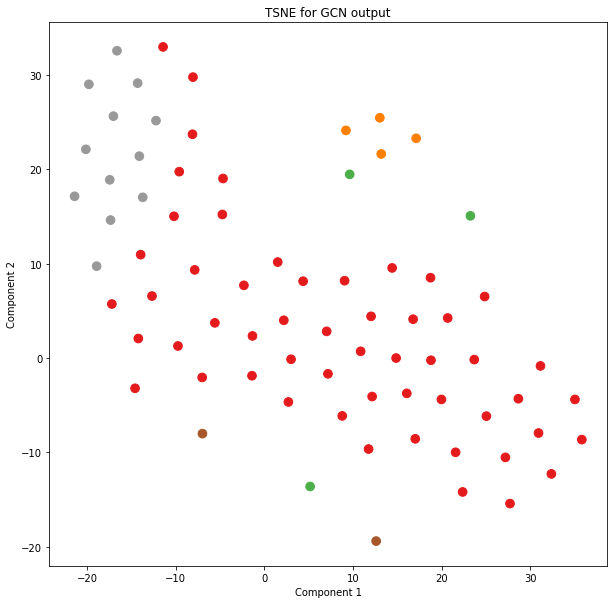

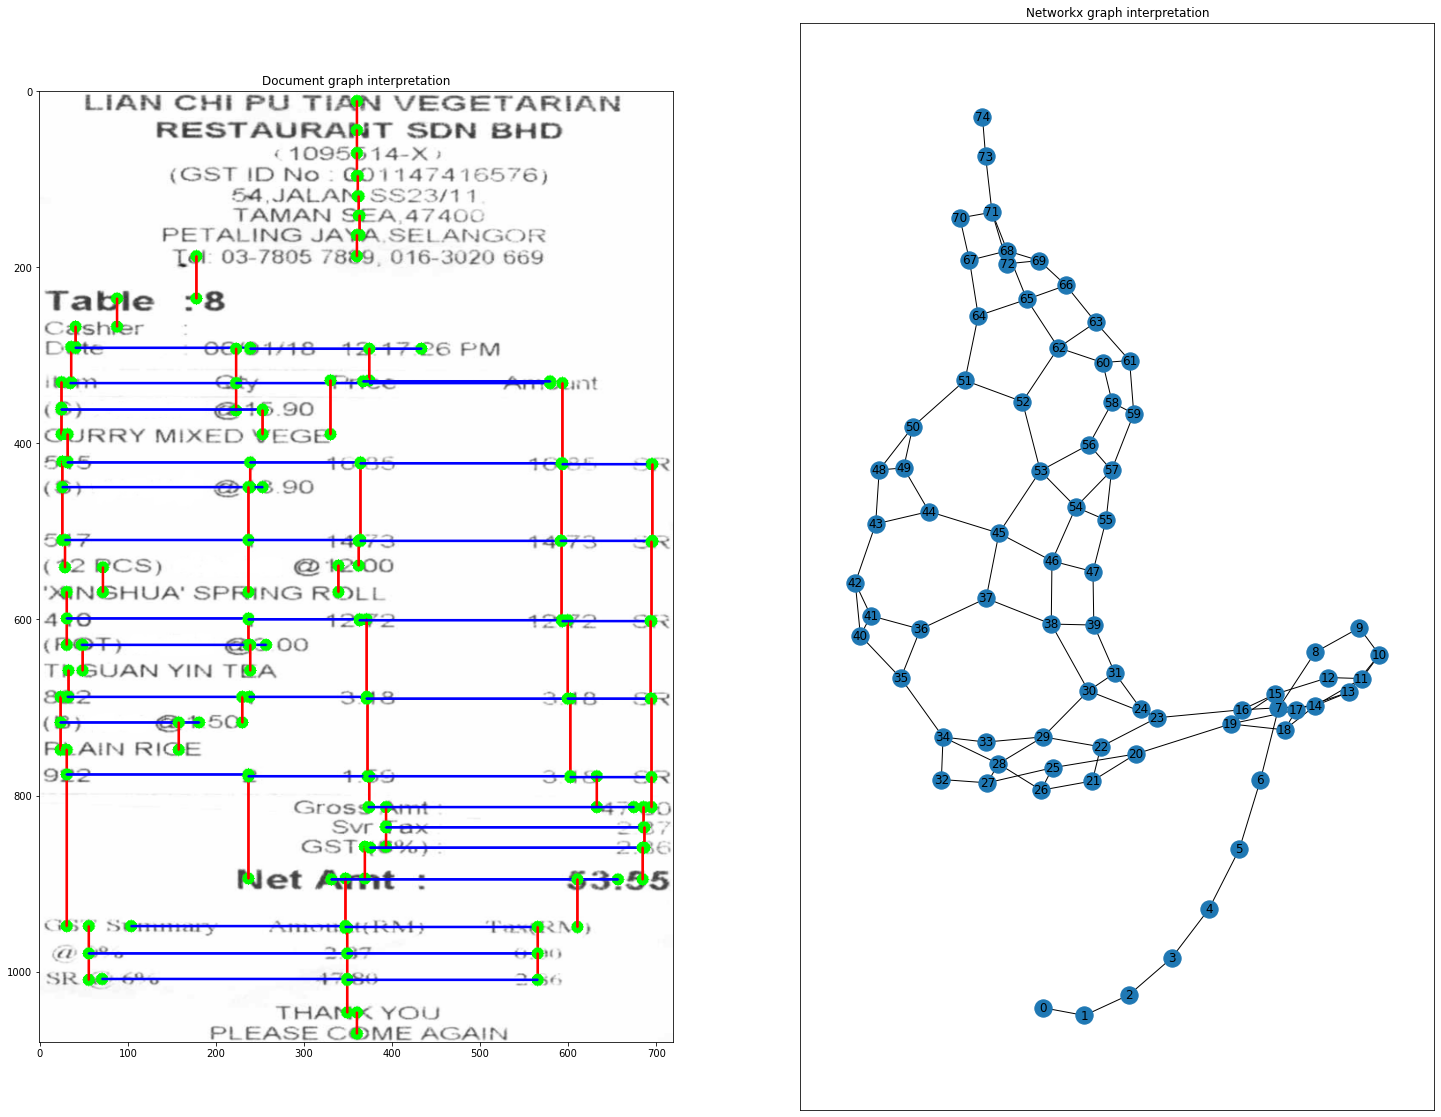

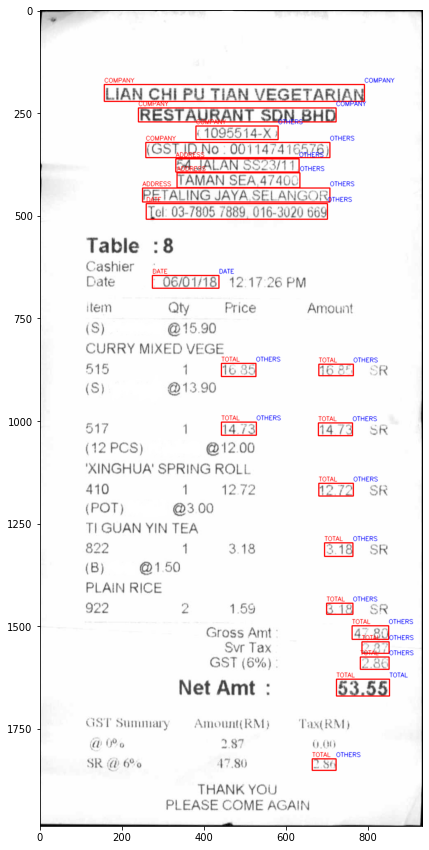

In [51]:
test_df_record_with_key = test_with_labels_df_ocr_processed[test_with_labels_df_ocr_processed['image'] == random.choice(test_with_labels_df_ocr_processed['image'].unique().tolist())]
res_with_key = inference(test_df_record_with_key, LitGCN.load_from_checkpoint(checkpoint_path=conf.MODEL_SAVED_PATH + '/' +'spectral_gcn' +'/version_0/checkpoints/epoch=732-step=1465.ckpt', ce_weights=ce_weights, is_spectral=True))

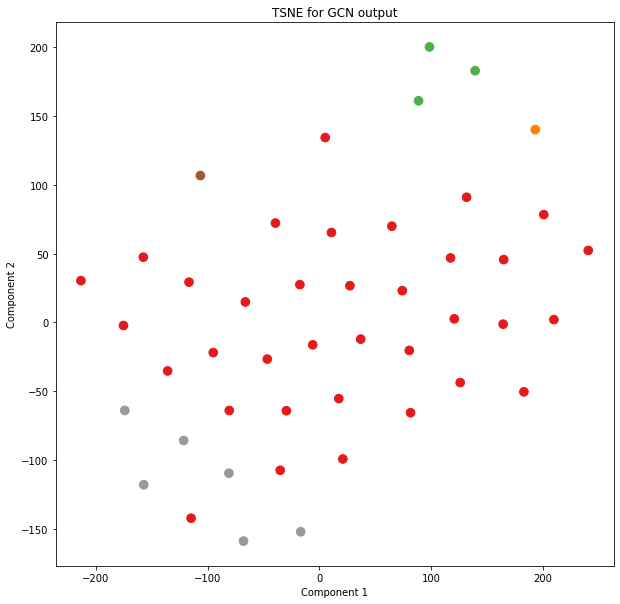

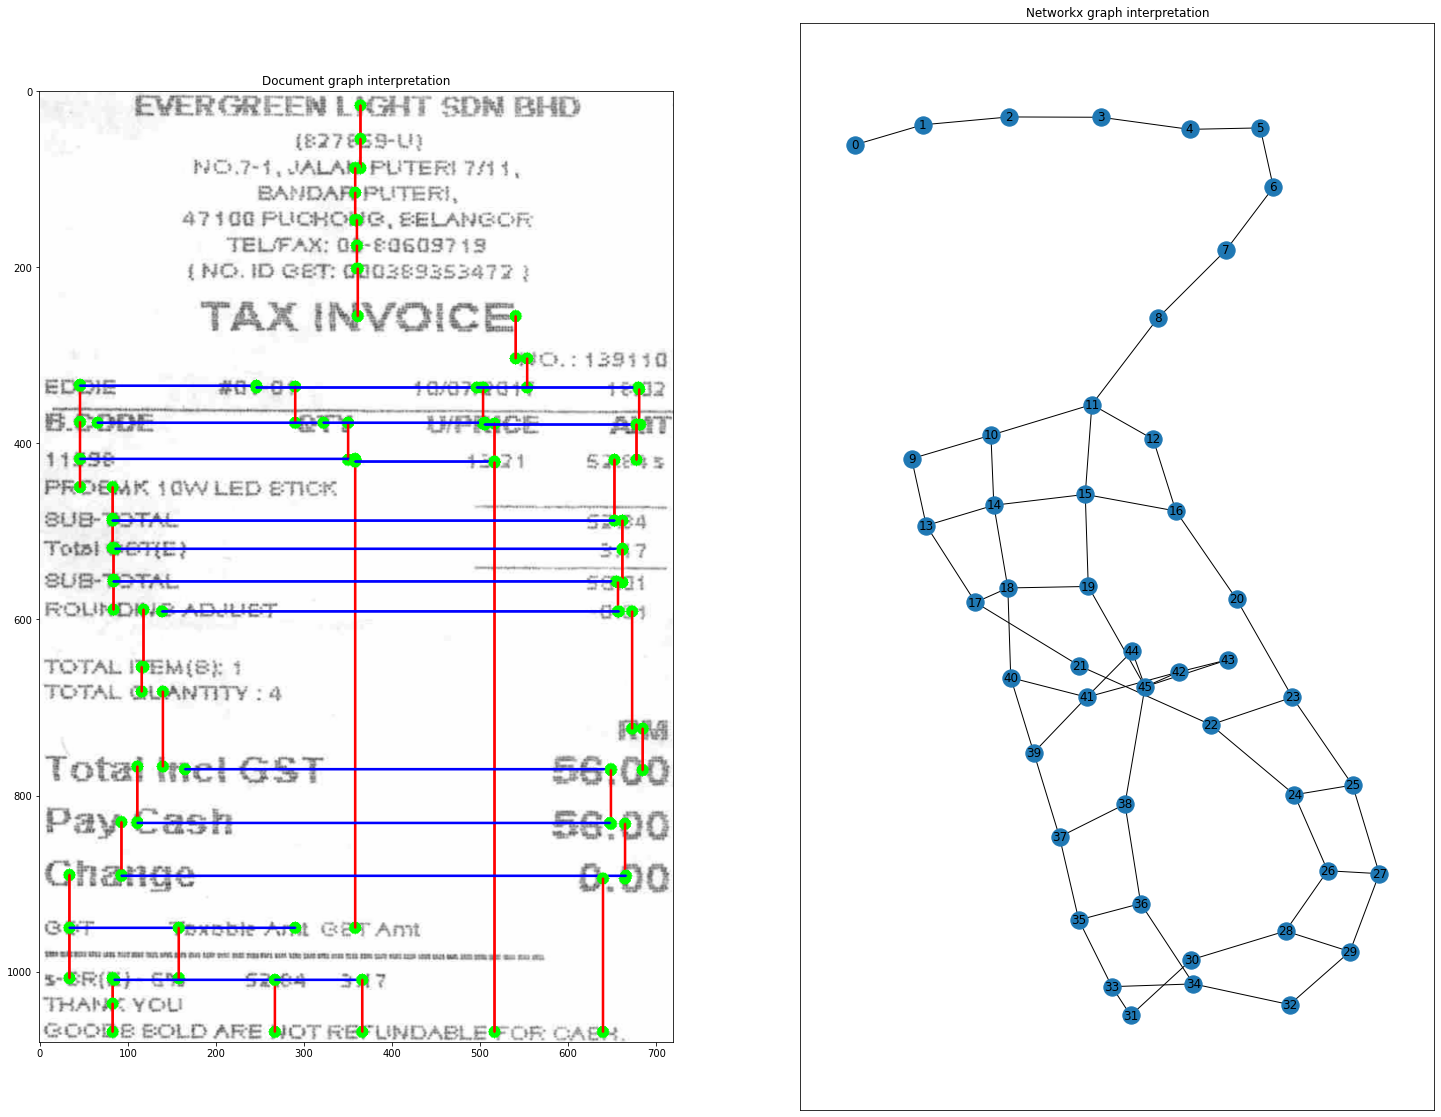

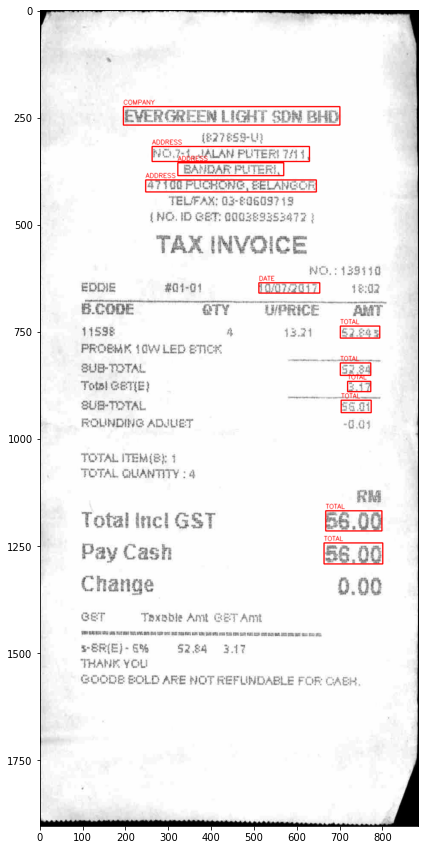

In [52]:
test_df_record = test_df_ocr_processed[test_df_ocr_processed['image'] == random.choice(test_df_ocr_processed['image'].unique().tolist())]
res = inference(test_df_record, LitGCN.load_from_checkpoint(checkpoint_path=conf.MODEL_SAVED_PATH + '/' +'spectral_gcn' +'/version_0/checkpoints/epoch=732-step=1465.ckpt', ce_weights=ce_weights, is_spectral=True))